<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_Silica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process**

# **(Silica Concentrate)**

## **1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

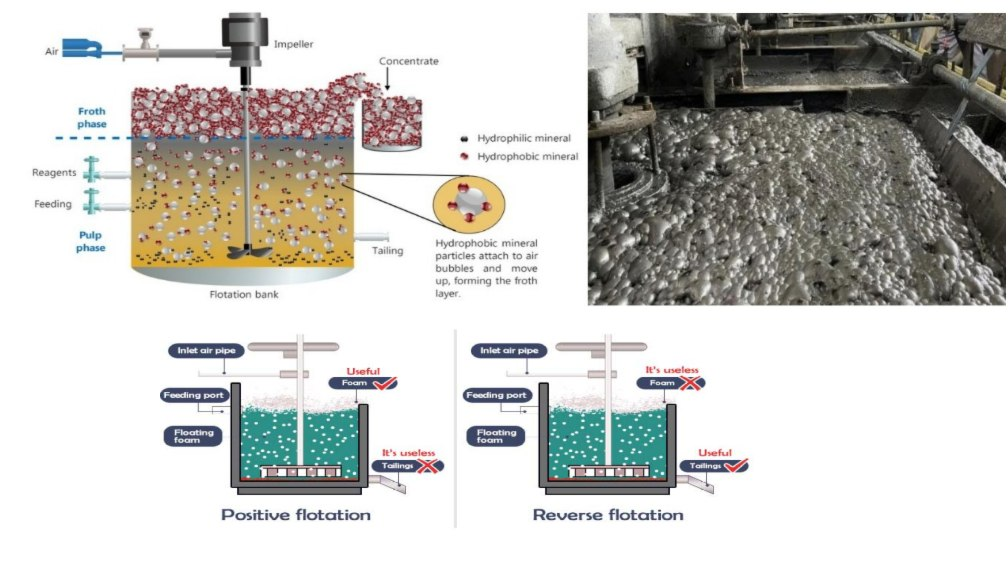

Flotation concentrate is periodically sampled to determine its purity (percentage of gangue). Higher purity in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict iron and gangue (silica) concentrate in the flotation output. The prediction will help process engineers assess the purity and take corrective actions in advance.

Source of dataset: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time. (There is imbalance in measurement of variables)
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

### **2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017).
- Measurements are taken every 5-6 hours for the first 2 columns (input - raw material).
- Measurements are taken every 1 hour for the last 2 columns (output - processed material).
- Some columns were sampled every 20 second.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant.
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process.
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality).
- The last two columns are the final iron ore pulp quality measurement from the lab.

### **2.3. Aim of the Project**

- To predict the percentage of output (iron and silica) concentrate in the mineral processing (reverse cationic flotation) plant

##**3. Data Collection**

###**3.1. Import Libraries**

In [1]:
import math
import random
import time
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, pearsonr
from scipy.cluster import hierarchy as hc
warnings.filterwarnings("ignore")
sns.set_theme(color_codes=True)
%matplotlib inline
import warnings

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

###**3.2. Import Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv')

Mounted at /content/drive/
/content/drive/My Drive/Flotation


##**4. Data Preprocessing**

###**4.1. Dataset Information**

In [3]:
flotation.sample(5).T

605928               330082  \
date                          2017-08-10 13:00:00  2017-06-07 16:00:00   
% Iron Feed                                 48,81                64,03   
% Silica Feed                               25,31                 6,26   
Starch Flow                               2347,66              3823,66   
Amina Flow                                489,407              549,662   
Ore Pulp Flow                      382,2222413793              405,125   
Ore Pulp pH                               9,61558              10,2298   
Ore Pulp Density                          1,68588              1,66616   
Flotation Column 01 Air Flow              299,629              297,204   
Flotation Column 02 Air Flow              299,312              252,418   
Flotation Column 03 Air Flow              297,807              298,035   
Flotation Column 04 Air Flow       304,3070017831              300,433   
Flotation Column 05 Air Flow       299,0429115624              298,073   
Flotation Column 06 Air Flow              343,129              299,669   
Flotation Column 07 Air Flow              350,022              300,509   
Flotation Column 01 Level          854,5455392419               634,62   
Flotation Column 02 Level                 520,691              452,757   
Flotation Column 03 Level                 513,529              444,379   
Flotation Column 04 Level                 340,695           296,493184   
Flotation Column 05 Level                 355,156              382,315   
Flotation Column 06 Level                  357,38              357,171   
Flotation Column 07 Level                  310,36              347,871   
% Iron Concentrate                           63,4                65,18   
% Silica Concentrate                          3,8                 2,88   

                                           73542                88159   \
date                          2017-04-09 07:00:00  2017-04-12 16:00:00   
% Iron Feed                                 56,39                56,77   
% Silica Feed                               13,53                11,98   
Starch Flow                                1844,3              2200,87   
Amina Flow                                439,271              532,801   
Ore Pulp Flow                             398,791              389,106   
Ore Pulp pH                               9,71822              9,73089   
Ore Pulp Density                          1,73046              1,73146   
Flotation Column 01 Air Flow               251,18                251,8   
Flotation Column 02 Air Flow              247,758              251,811   
Flotation Column 03 Air Flow              249,505              250,264   
Flotation Column 04 Air Flow              295,096       296,1823782991   
Flotation Column 05 Air Flow                306,4       302,7157651015   
Flotation Column 06 Air Flow               250,06              253,768   
Flotation Column 07 Air Flow              253,229               250,27   
Flotation Column 01 Level                 601,452              606,114   
Flotation Column 02 Level                 599,808              723,828   
Flotation Column 03 Level                 589,756              585,466   
Flotation Column 04 Level          170,1850961538              467,159   
Flotation Column 05 Level                 465,754              486,277   
Flotation Column 06 Level                 414,939              449,297   
Flotation Column 07 Level                 456,621              464,757   
% Iron Concentrate                          65,79                62,59   
% Silica Concentrate                         2,31                 4,88   

                                           168695  
date                          2017-05-01 08:00:00  
% Iron Feed                                 51,71  
% Silica Feed                               20,44  
Starch Flow                        122,2277909091  
Amina Flow                                529,974  
Ore Pulp Flow                

In [4]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flow  737453 non-null  object
 13 

In [5]:
flotation.describe().T

count  unique                  top    freq
date                          737453    4097  2017-06-16 15:00:00     180
% Iron Feed                   737453     278                64,03  142560
% Silica Feed                 737453     293                 6,26  142560
Starch Flow                   737453  409317               2562,5     690
Amina Flow                    737453  319416              534,668     959
Ore Pulp Flow                 737453  180189              402,246    1735
Ore Pulp pH                   737453  131143              10,0591    1509
Ore Pulp Density              737453  105805                 1,75    3214
Flotation Column 01 Air Flow  737453   43675              299,927   13683
Flotation Column 02 Air Flow  737453   80442              255,322    1487
Flotation Column 03 Air Flow  737453   40630              298,828    6012
Flotation Column 04 Air Flow  737453  196006              295,096   82829
Flotation Column 05 Air Flow  737453  194711                306,4   82832
Flotation Column 06 Air Flow  737453   90548              299,927   13766
Flotation Column 07 Air Flow  737453   86819              299,487    3405
Flotation Column 01 Level     737453  299573              452,441    1013
Flotation Column 02 Level     737453  331189              608,887     817
Flotation Column 03 Level     737453  322315               601,06     989
Flotation Column 04 Level     737453  309264              491,406     733
Flotation Column 05 Level     737453  276051              513,879     709
Flotation Column 06 Level     737453  301502               474,37     746
Flotation Column 07 Level     737453  295667              479,478     905
% Iron Concentrate            737453   38696                65,44   16920
% Silica Concentrate          737453   55569                 2,08   17100

- Date: The data spans across multiple dates, with the most frequent date being 2017-06-16 15:00:00, which appears 180 times.

- % Iron Feed: This variable ranges across 278 unique values. The most frequent value is 64.03, which occurs 142,560 times.

- % Silica Feed: Similar to % Iron Feed, % Silica Feed also has 293 unique values. The most frequent value is 6.26, which occurs 142,560 times.

- Starch Flow: Starch Flow shows a wide range of values, with 409,317 unique values. The most frequent value is 2562.5, which occurs 690 times.

- Amina Flow: Amina Flow also displays a diverse range of values, with 319,416 unique values. The most frequent value is 534.668, which occurs 959 times.

- Ore Pulp Flow: Ore Pulp Flow has 180,189 unique values. The most frequent value is 402.246, which occurs 1,735 times.

- Ore Pulp pH: Ore Pulp pH exhibits 131,143 unique values. The most frequent value is 10.0591, which occurs 1,509 times.

- Ore Pulp Density: Ore Pulp Density has 105,805 unique values. The most frequent value is 1.75, which occurs 3,214 times.

- Flotation Column Air Flow: Each of the flotation columns (01 to 07) has unique airflow values. The frequency of these values varies across columns.

- Flotation Column Level: Similar to the airflow, each flotation column (01 to 07) has unique level values. The frequency of these values also varies across columns.

**Target Variables:**

- % Iron Concentrate: % Iron Concentrate ranges across 38,696 unique values. The most frequent value is 65.44, which occurs 16,920 times.

- % Silica Concentrate: % Silica Concentrate has 55,569 unique values. The most frequent value is 2.08, which occurs 17,100 times.

###**4.2.  Apply Corrections on Dataset**

**There are a lot of unreasonable values in some variables:**

- Ore Pulp Flow (plant input ore slury) is aproximately 400 t/h.
- When we look the Ore Pulp Flow column most of the values with different decimal figures ("394,57" - "568848") in tons/hour
- Starch Flow and Amina Flow columns have different unbalanced values ("3019,53" - "367383" - "3121" - "1645,3466666667") in m³/hour
- Ore Pulp Density has not any problem ("1,74" - "1,78055")
- Ore Pulp pH must  be in range 0-14. But some values in thousands ("10068" - "9,95376", "9602")
- Flotation Column Air Flow values ("249.214" - "300.2481959288") in Nm³/h
- Flotation Column Level values ("453.942" - "868.6261818182") in mm
- There is no problem in % Iron Concentrate, % Silica Concentrate columns




**Corrections**

In [6]:
columns_to_convert = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate',
                      '% Silica Concentrate', 'Ore Pulp Density']

for column in columns_to_convert:
    flotation[column] = flotation[column].str.replace(',', '.').astype(float).round(2)

In [7]:
columns_to_update = ["Starch Flow", "Amina Flow", "Ore Pulp Flow"]

flotation[columns_to_update] = (flotation[columns_to_update].replace(",", "", regex=True)
                               .apply(lambda x: x.str[:3] + "." + x.str[3:])
                               .astype(float).round(3))

In [8]:
flotation["Ore Pulp pH"] = (flotation["Ore Pulp pH"].str.replace(",", ".", regex=True)
                           .apply(lambda x: float(x[:2] + x[2:].replace(".", ""))
                           if "," in x else float(x)).round(2))

In [9]:
columns_to_update = ["Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                     "Flotation Column 04 Air Flow", "Flotation Column 05 Air Flow", "Flotation Column 06 Air Flow",
                     "Flotation Column 07 Air Flow"]

for column in columns_to_update:
    flotation[column] = flotation[column].str.replace(",", "")
    flotation[column] = flotation[column].apply(lambda x: "{:d}.{:s}".format(int(x[:3]), x[3:]) if len(x) > 3 else np.nan)
    flotation[column] = flotation[column].astype('float64').round(3)

In [10]:
columns_to_update = ["Flotation Column 01 Level", "Flotation Column 02 Level", "Flotation Column 03 Level",
                     "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level",
                     "Flotation Column 07 Level"]

for column in columns_to_update:
    flotation[column] = flotation[column].str.replace(",", "")
    flotation[column] = flotation[column].apply(lambda x: "{:d}.{:s}".format(int(x[:3]), x[3:]) if len(x) > 3 else np.nan)
    flotation[column] = flotation[column].astype('float64').round(3)

In [11]:
flotation['Airflow'] = flotation[["Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow",
                                  "Flotation Column 03 Air Flow", "Flotation Column 04 Air Flow",
                                  "Flotation Column 05 Air Flow", "Flotation Column 06 Air Flow",
                                  "Flotation Column 07 Air Flow"]].mean(axis=1).round(3)

flotation.drop(["Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow",
                "Flotation Column 03 Air Flow", "Flotation Column 04 Air Flow",
                "Flotation Column 05 Air Flow", "Flotation Column 06 Air Flow",
                "Flotation Column 07 Air Flow"], axis=1, inplace=True)

In [12]:
flotation['Level'] = flotation[["Flotation Column 01 Level", "Flotation Column 02 Level",
                                "Flotation Column 03 Level", "Flotation Column 04 Level",
                                "Flotation Column 05 Level", "Flotation Column 06 Level",
                                "Flotation Column 07 Level"]].mean(axis=1).round(3)

flotation.drop(["Flotation Column 01 Level", "Flotation Column 02 Level",
                "Flotation Column 03 Level", "Flotation Column 04 Level",
                "Flotation Column 05 Level", "Flotation Column 06 Level",
                "Flotation Column 07 Level"], axis=1, inplace=True)

In [13]:
flotation.sample(5).T

283077               399492  \
date                  2017-05-27 19:00:00  2017-06-23 18:00:00   
% Iron Feed                         64.03                52.28   
% Silica Feed                        6.26                19.47   
Starch Flow                        245.04              211.652   
Amina Flow                        433.748              557.373   
Ore Pulp Flow                     399.072              389.853   
Ore Pulp pH                         10.18                 10.0   
Ore Pulp Density                     1.67                 1.68   
% Iron Concentrate                  66.14                66.19   
% Silica Concentrate                 1.33                 2.43   
Airflow                           299.735              297.933   
Level                             484.026               411.08   

                                   200515               296652  \
date                  2017-05-08 17:00:00  2017-05-30 23:00:00   
% Iron Feed                         56.65                64.03   
% Silica Feed                       14.83                 6.26   
Starch Flow                       275.309              290.509   
Amina Flow                        526.616              570.426   
Ore Pulp Flow                     393.824              408.376   
Ore Pulp pH                          9.98                10.09   
Ore Pulp Density                     1.72                 1.72   
% Iron Concentrate                  65.74                66.21   
% Silica Concentrate                 1.98                 1.48   
Airflow                           279.234              300.085   
Level                             406.179              545.464   

                                   416860  
date                  2017-06-27 18:00:00  
% Iron Feed                         52.41  
% Silica Feed                       21.29  
Starch Flow                       442.656  
Amina Flow                        596.405  
Ore Pulp Flow                     398.267  
Ore Pulp pH                          9.64  
Ore Pulp Density                     1.72  
% Iron Concentrate                  62.32  
% Silica Concentrate                 5.37  
Airflow                           300.312  
Level                              403.82

###**4.3. Check Missing & Duplicated Values**

In [14]:
missing_values = flotation.isnull().sum()
print(missing_values)

date                    0
% Iron Feed             0
% Silica Feed           0
Starch Flow             0
Amina Flow              0
Ore Pulp Flow           0
Ore Pulp pH             0
Ore Pulp Density        0
% Iron Concentrate      0
% Silica Concentrate    0
Airflow                 0
Level                   0
dtype: int64


- There are no missing values in the the dataframe

In [15]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

date                    1449
% Iron Feed             1449
% Silica Feed           1449
Starch Flow             1449
Amina Flow              1449
Ore Pulp Flow           1449
Ore Pulp pH             1449
Ore Pulp Density        1449
% Iron Concentrate      1449
% Silica Concentrate    1449
Airflow                 1449
Level                   1449
dtype: int64

In [16]:
# Count the number of duplicate rows
num_duplicates = flotation.duplicated().sum()
# Drop the duplicate rows from the DataFrame
flotation.drop_duplicates(inplace=True)
# Verify that duplicate rows have been eliminated
print("Number of duplicate rows:", num_duplicates)
print("Number of rows after removing duplicates:", len(flotation))

Number of duplicate rows: 1449
Number of rows after removing duplicates: 736004


In [17]:
flotation.columns

Index(['date', '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       '% Iron Concentrate', '% Silica Concentrate', 'Airflow', 'Level'],
      dtype='object')

### **4.4. Rename Columns**

In [18]:
# Rename column names
old_columns = ['date', '% Iron Feed', '% Silica Feed',
               'Starch Flow', 'Amina Flow', 'Ore Pulp Flow',
               'Ore Pulp pH', 'Ore Pulp Density', '% Iron Concentrate',
               '% Silica Concentrate', 'Airflow', 'Level']

new_columns = ["date","iron_feed", "silica_feed",
               "starch_flow", "amina_flow", "pulp_flow",
               "pulp_pH", "pulp_density", "iron_conc",
               "silica_conc", "airflow", "level"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['date', 'iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
       'pulp_flow', 'pulp_pH', 'pulp_density', 'iron_conc', 'silica_conc',
       'airflow', 'level'],
      dtype='object')

In [19]:
flotation.sample(5).T

451789               384823               402133  \
date          2017-07-05 20:00:00  2017-06-20 08:00:00  2017-06-24 09:00:00   
iron_feed                   53.63                50.75                52.11   
silica_feed                 15.74                20.45                18.64   
starch_flow               293.823              351.828               350.78   
amina_flow                575.882              604.049              424.514   
pulp_flow                  403.32              403.898              401.822   
pulp_pH                     10.12                 9.91                 8.87   
pulp_density                 1.73                 1.74                 1.52   
iron_conc                   65.12                62.78                67.04   
silica_conc                  1.87                 4.13                 0.86   
airflow                   299.592              297.869              299.338   
level                     440.136              434.624              404.502   

                           311859               353817  
date          2017-06-03 11:00:00  2017-06-13 04:00:00  
iron_feed                   64.03                64.03  
silica_feed                  6.26                 6.26  
starch_flow               232.291              331.002  
amina_flow                270.676               458.44  
pulp_flow                 411.503               403.25  
pulp_pH                      9.86                  9.5  
pulp_density                 1.56                 1.56  
iron_conc                    64.8                64.54  
silica_conc                  2.43                 1.71  
airflow                   292.291              300.491  
level                     658.857              498.353

In [20]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736004 entries, 0 to 737452
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          736004 non-null  object 
 1   iron_feed     736004 non-null  float64
 2   silica_feed   736004 non-null  float64
 3   starch_flow   736004 non-null  float64
 4   amina_flow    736004 non-null  float64
 5   pulp_flow     736004 non-null  float64
 6   pulp_pH       736004 non-null  float64
 7   pulp_density  736004 non-null  float64
 8   iron_conc     736004 non-null  float64
 9   silica_conc   736004 non-null  float64
 10  airflow       736004 non-null  float64
 11  level         736004 non-null  float64
dtypes: float64(11), object(1)
memory usage: 73.0+ MB


### **4.5. Grouping Rows With Hourly Frequency**

The importance of considering plant data as a holistic entity was emphasized in order to gain a comprehensive understanding. To achieve this, a loop-based analysis methodology was employed. Each row of data was treated as an individual iteration, representing a complete cycle of feeding 100 tons of ore to the plant, enriching it, and concluding the process. For the purpose of this study, each cycle was set at a duration of one hour. Consequently, a photograph of the plant was captured at hourly intervals and subjected to analysis. It is worth noting that if a more frequent and regular data collection scheme were in place, such as cycles occurring every minute, it would yield a larger dataset suitable for machine learning applications.

In [21]:
flotation['date'] = pd.to_datetime(flotation['date'])
#grouping the data according to the hours and get their average values.
flotation_grouped = flotation.groupby(pd.Grouper(key='date',freq='H')).mean()
# cycle_data.insert(0,'Date',cycle_data.index)
flotation_grouped.reset_index(inplace = True)

#some rows have 'null' values because of timing. We need to drop them
print('Shape of Grouped Flotation Dataset = ', flotation_grouped.shape)
flotation = flotation_grouped.dropna()
print('Shape of Grouped Flotation Dataset after drop null values = ', flotation.shape);

Shape of Grouped Flotation Dataset =  (4415, 12)
Shape of Grouped Flotation Dataset after drop null values =  (4097, 12)


The grouping process has a number of advantages and disadvantages.

**Advantages:**
Each analysis will be able to do each data cycle on an hourly frequency.
Date column can be dropped. The number of columns fell to 23.
The number of rows fell to 4097 from 737453. Every rows means calculations on computer.

**Disadvantage:** The number of rows fell to 4097 from 737453. The more rows we have for machine learning, the better results we get. This large data loss will adversely affect our estimation results.

**Dropping unnecessary date column**

In [22]:
flotation_copy = flotation.copy()
flotation_copy.drop(['date'], axis=1, inplace=True)

In [23]:
missing_values = flotation.isnull().sum()
print(missing_values)

date            0
iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
iron_conc       0
silica_conc     0
airflow         0
level           0
dtype: int64


In [24]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

date            0
iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
iron_conc       0
silica_conc     0
airflow         0
level           0
dtype: int64

### **4.6. Reorder the Columns**

In [25]:
column_order = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
                'pulp_density', 'airflow', 'level', 'iron_conc', 'silica_conc']

flotation = flotation.reindex(columns=column_order)
flotation.columns

Index(['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow', 'level', 'iron_conc',
       'silica_conc'],
      dtype='object')

##**5. Exploratory Data Analysis**

###**5.1. Corellation Between the Variables**

In [26]:
flotation.describe().T

count        mean        std         min         25%  \
iron_feed     4097.0   56.294730   5.158347   42.740000   52.670000   
silica_feed   4097.0   14.651733   6.808236    1.310000    8.940000   
starch_flow   4097.0  338.145985  92.676974  102.567372  283.586733   
amina_flow    4097.0  488.160974  83.694176  242.927478  436.037967   
pulp_flow     4097.0  397.576497   8.370236  376.837611  398.848778   
pulp_pH       4097.0    9.767644   0.378189    8.750000    9.540889   
pulp_density  4097.0    1.680348   0.063875    1.520000    1.651389   
airflow       4097.0  288.656648  18.520292  221.601528  278.442433   
level         4097.0  467.251792  74.329034  340.585206  399.868750   
iron_conc     4097.0   65.050082   1.118100   62.050000   64.370000   
silica_conc   4097.0    2.326751   1.124779    0.600000    1.440000   

                     50%         75%         max  
iron_feed      56.080000   59.720000   65.780000  
silica_feed    13.850000   19.600000   33.400000  
starch_flow   335.505333  382.469011  963.312061  
amina_flow    502.454283  549.522256  736.982378  
pulp_flow     399.841022  400.582233  418.070233  
pulp_pH         9.795944   10.030944   10.810000  
pulp_density    1.695722    1.721722    1.832667  
airflow       299.804678  299.975556  316.005211  
level         456.894706  514.546728  745.230456  
iron_conc      65.210000   65.860000   68.010000  
silica_conc     2.000000    3.010000    5.530000

- Iron Feed: The iron feed values range from 42.74 to 65.78 with a mean of 56.295. The standard deviation indicates moderate variability in the data.

- Silica Feed: The silica feed values range from 1.31 to 33.4 with a mean of 14.652. The data shows a wider range and higher variability compared to the iron feed.

- Starch Flow: The starch flow values range from 102.567 to 963.312 with a mean of 338.146. There is a considerable range in values, indicating significant variability in starch flow.

- Amina Flow: The amina flow values range from 242.927 to 736.982 with a mean of 488.161. The data shows moderate variability.

- Pulp Flow: The pulp flow values range from 376.838 to 418.07 with a mean of 397.576. The data indicates relatively low variability.

- Pulp pH: The pulp pH values range from 8.75 to 10.81 with a mean of 9.768. The data shows moderate variability.

- Pulp Density: The pulp density values range from 1.52 to 1.833 with a mean of 1.68. The data indicates moderate variability.

- Airflow: The airflow values range from 221.602 to 316.005 with a mean of 288.657. The data shows moderate variability.

- Level: The level values range from 340.585 to 745.23 with a mean of 467.252. The data indicates moderate variability.

**Target Variables:**

- Iron Concentrate: The iron concentrate values range from 62.05 to 68.01 with a mean of 65.05. The data shows relatively low variability.

- Silica Concentrate: The silica concentrate values range from 0.6 to 5.53 with a mean of 2.327. The data shows higher variability compared to the iron concentrate.

In [27]:
flotation.corr()

iron_feed  silica_feed  starch_flow  amina_flow  pulp_flow  \
iron_feed      1.000000    -0.971833    -0.012753   -0.096215   0.186379   
silica_feed   -0.971833     1.000000     0.029140    0.085890  -0.174834   
starch_flow   -0.012753     0.029140     1.000000    0.039488   0.047801   
amina_flow    -0.096215     0.085890     0.039488    1.000000   0.237586   
pulp_flow      0.186379    -0.174834     0.047801    0.237586   1.000000   
pulp_pH        0.007458     0.008383     0.230099    0.134163   0.138802   
pulp_density  -0.136404     0.113417    -0.118724    0.659765   0.019916   
airflow       -0.080216     0.107268     0.143422    0.131672  -0.181273   
level          0.028466    -0.049391    -0.097972   -0.324536  -0.030256   
iron_conc      0.055453    -0.044189     0.035205   -0.120415   0.096595   
silica_conc   -0.077114     0.072782    -0.043536    0.171142   0.009619   

               pulp_pH  pulp_density   airflow     level  iron_conc  \
iron_feed     0.007458     -0.136404 -0.080216  0.028466   0.055453   
silica_feed   0.008383      0.113417  0.107268 -0.049391  -0.044189   
starch_flow   0.230099     -0.118724  0.143422 -0.097972   0.035205   
amina_flow    0.134163      0.659765  0.131672 -0.324536  -0.120415   
pulp_flow     0.138802      0.019916 -0.181273 -0.030256   0.096595   
pulp_pH       1.000000      0.122639  0.182103 -0.121504   0.197962   
pulp_density  0.122639      1.000000 -0.023721 -0.148443   0.016802   
airflow       0.182103     -0.023721  1.000000 -0.461957   0.050338   
level        -0.121504     -0.148443 -0.461957  1.000000   0.072211   
iron_conc     0.197962      0.016802  0.050338  0.072211   1.000000   
silica_conc  -0.151422      0.050825 -0.165113 -0.078572  -0.801212   

              silica_conc  
iron_feed       -0.077114  
silica_feed      0.072782  
starch_flow     -0.043536  
amina_flow       0.171142  
pulp_flow        0.009619  
pulp_pH         -0.151422  
pulp_density     0.050825  
airflow         -0.165113  
level           -0.078572  
iron_conc       -0.801212  
silica_conc      1.000000

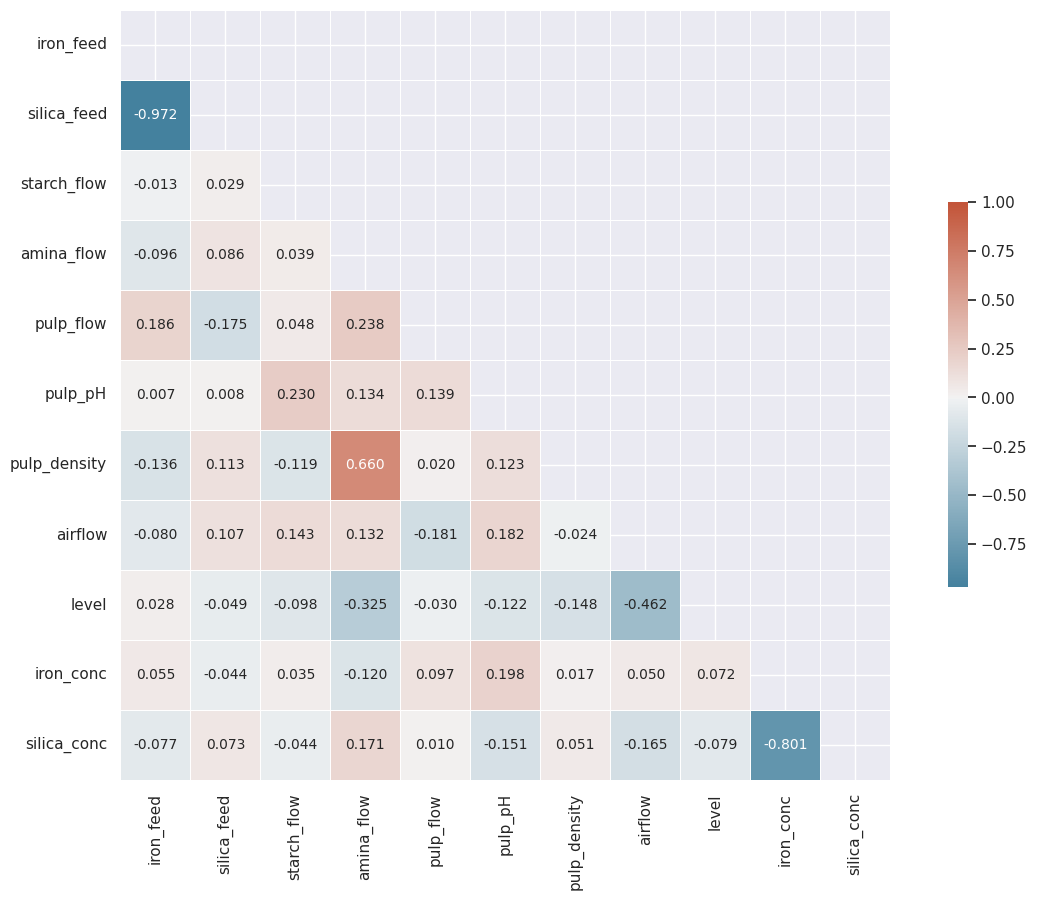

In [ ]:
# Correlation Heatmap
f, ax = plt.subplots(figsize=(15, 10))
mat = flotation.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1,
            center=0, annot = True, square=True,
            linewidths=.5, annot_kws={"fontsize": 10},
            cbar_kws={"shrink": .5}, fmt='.3f')
plt.show()

**Correlation between iron_conc and other variables:**
- Iron Concentrate (iron_conc) has a weak positive correlation with pulp_pH (0.197962), indicating that higher pulp pH values may be associated with higher iron concentrate levels.
- It has weak correlations close to zero with other variables such as iron_feed, silica_feed, starch_flow, amina_flow, pulp_flow, pulp_density, airflow, and level. This suggests a lack of significant linear relationships between iron_conc and these variables.
- Silica Concentrate (silica_conc) has a strong negative correlation with iron_conc (-0.801212), indicating an inverse relationship between the two target variables. As the iron concentrate increases, the silica concentrate tends to decrease, and vice versa.

**Correlation between silica_conc and other variables:**

- Silica Concentrate (silica_conc) has a weak positive correlation with silica_feed (0.072782), suggesting that higher silica feed values may be associated with higher silica concentrate levels.
- It has a weak negative correlation with airflow (-0.077114), indicating that higher airflow may be associated with lower silica concentrate levels.
- Other variables such as iron_feed, starch_flow, amina_flow, pulp_flow, pulp_pH, pulp_density, level, and iron_conc have correlations with silica_conc close to zero. This implies a lack of significant linear relationship between silica_conc and these variables.
- These correlation coefficients indicate the strength and direction of linear relationships between the variables. Further analysis will be done to understand the underlying factors and determine any causal relationships between the target variables (iron_conc and silica_conc) and the independent variables.

**Pairplot**

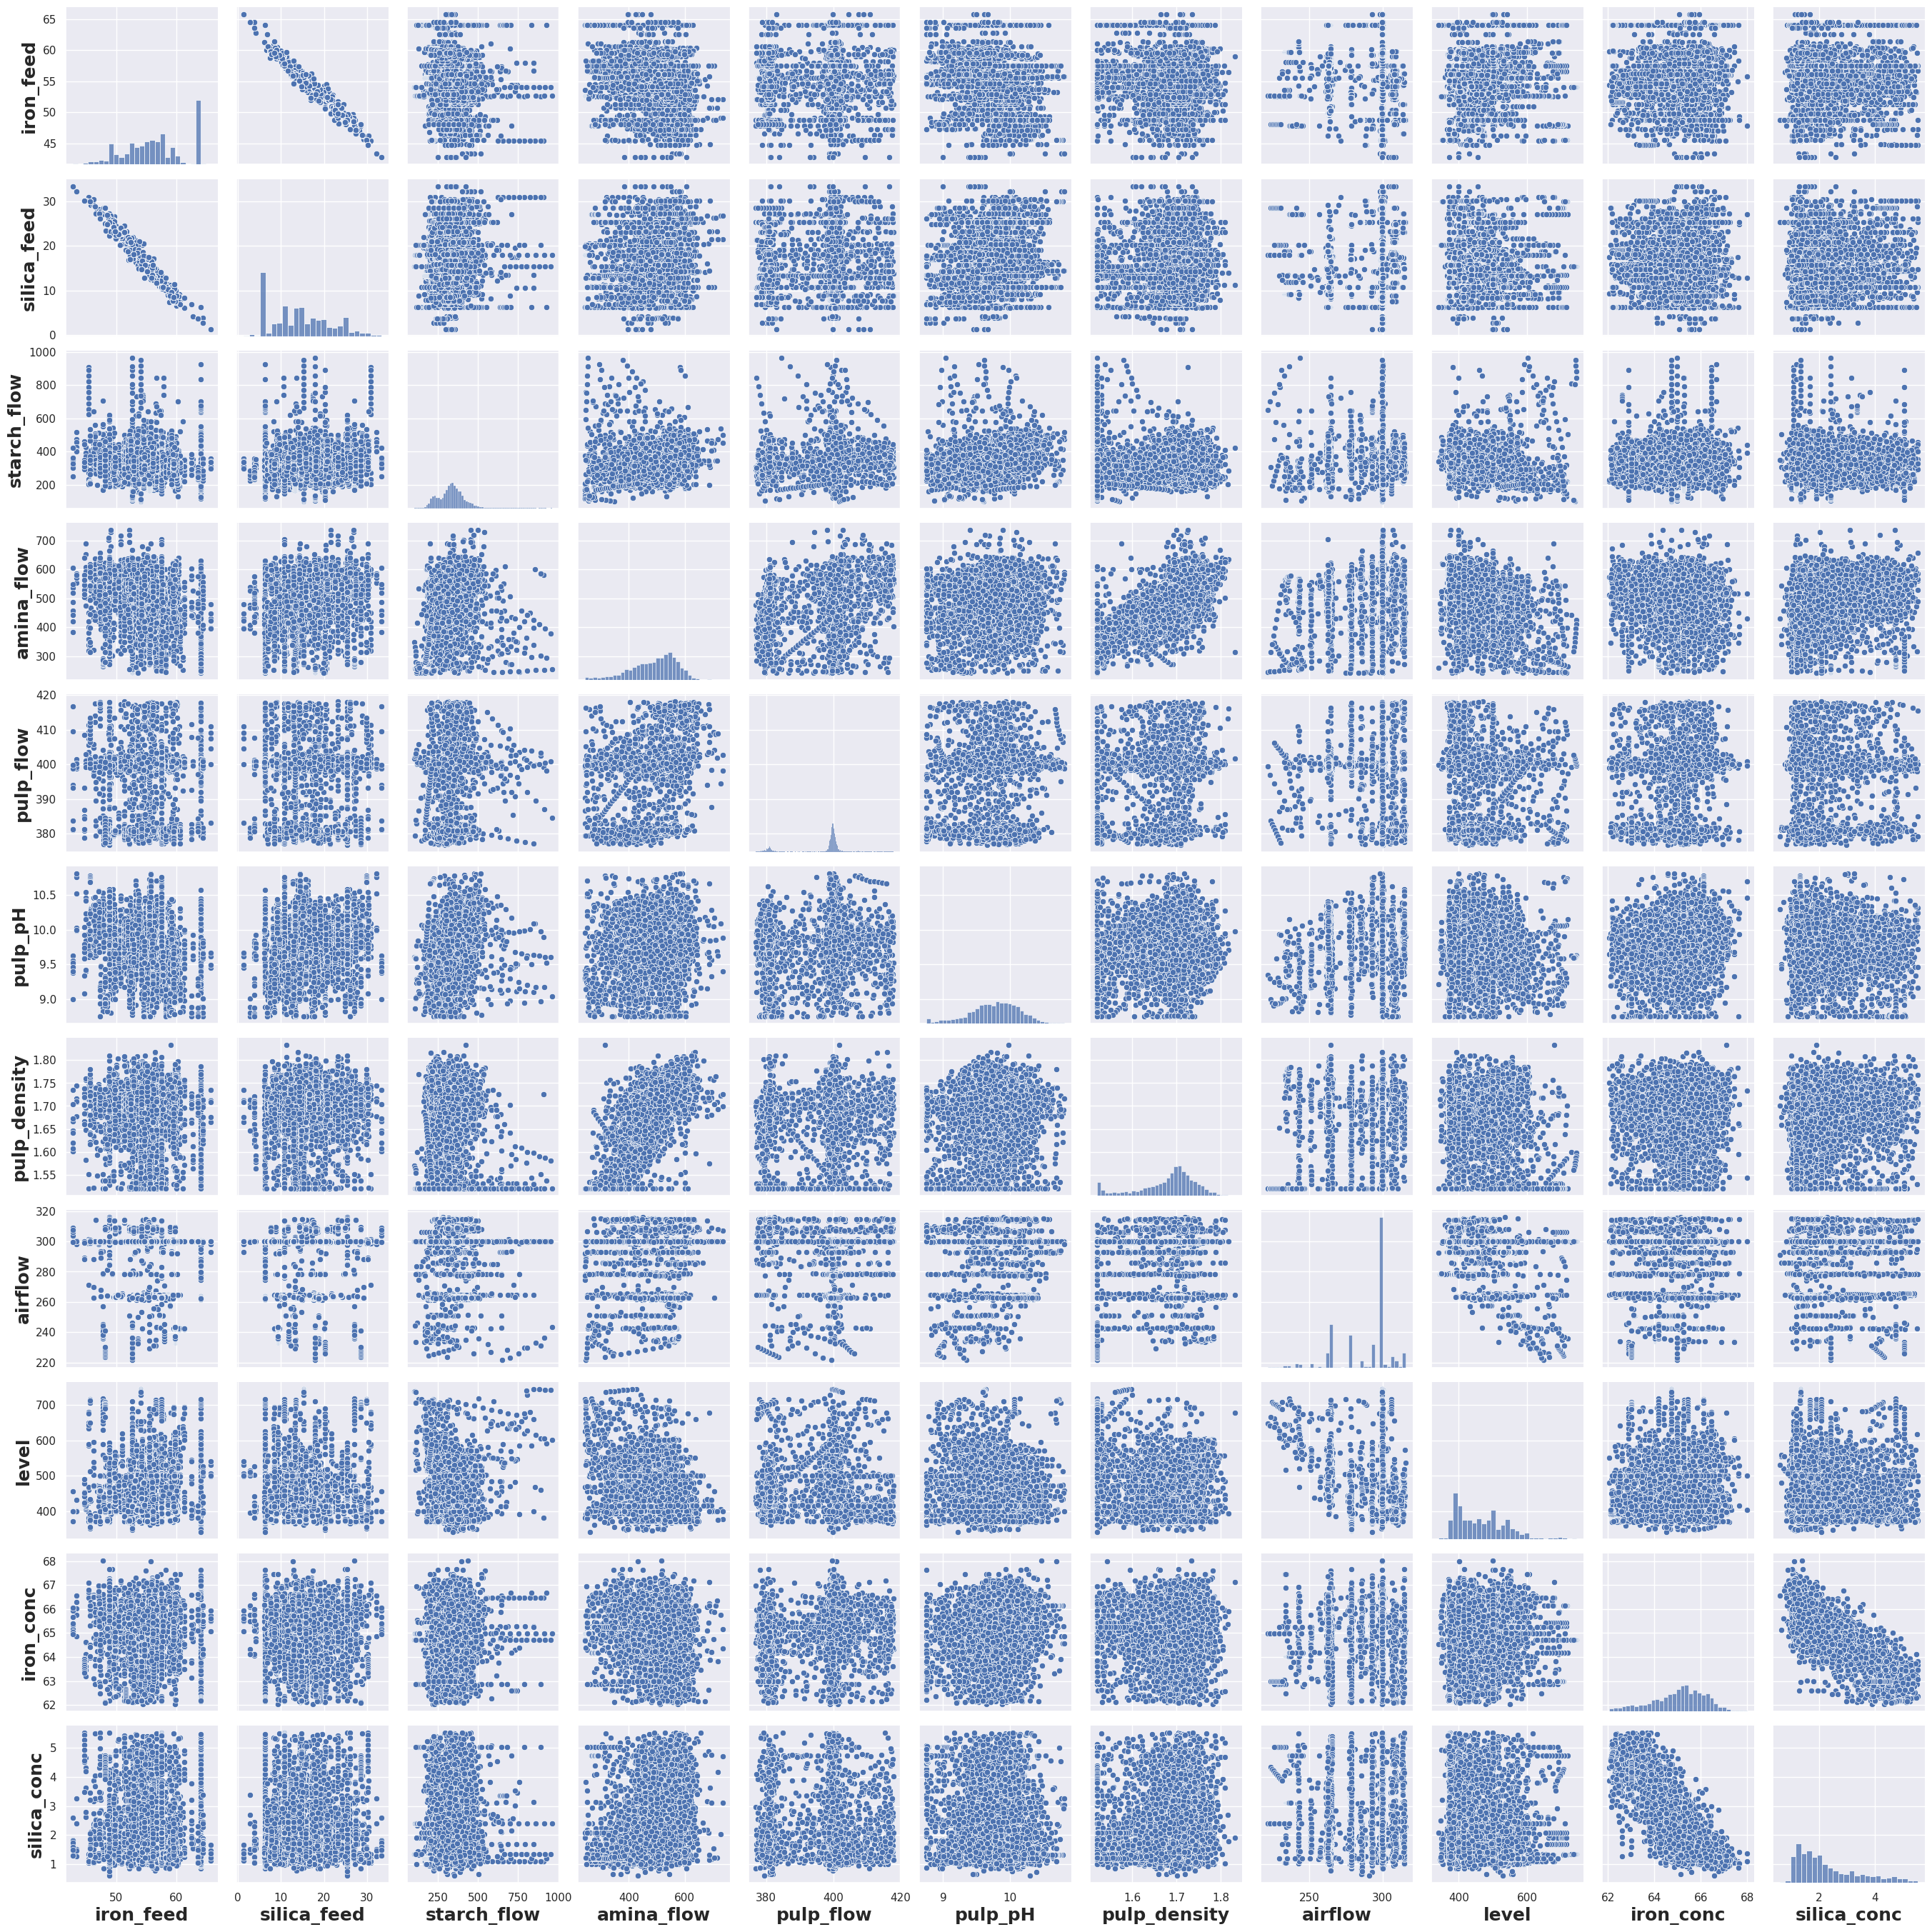

In [29]:
pairplot = sns.pairplot(flotation[columns])
for ax in pairplot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=18, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=18, fontweight='bold')

plt.show()

### **5.2. Relationships between target variable (Iron Concentrate) and Independent variables**

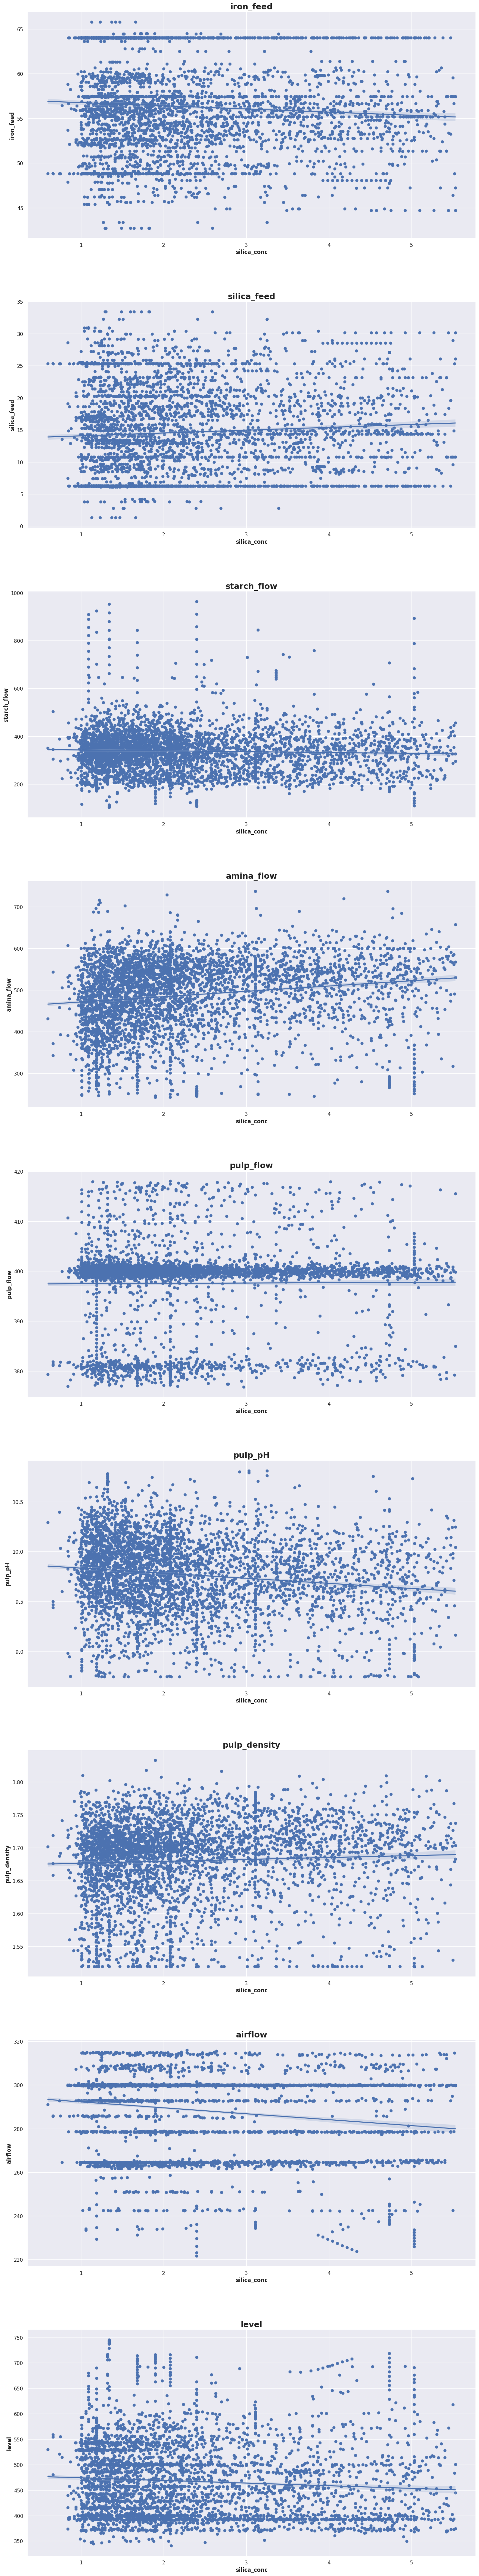

In [31]:
columns = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
           'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow', 'level']

num_plots = min(len(columns), 9)
fig, axs = plt.subplots(9, 1, figsize=(15, 80))
axs = axs.flatten()

for i in range(num_plots):
    col = columns[i]
    sns.scatterplot(data=flotation, x='silica_conc', y=col, ax=axs[i])
    sns.regplot(data=flotation, x='silica_conc', y=col, ax=axs[i])
    axs[i].set_title(f'{col}', fontsize=18, fontweight='bold')
    axs[i].set_xlabel('silica_conc', fontsize=12, fontweight='bold')
    axs[i].set_ylabel(col, fontsize=12, fontweight='bold')

plt.tight_layout(h_pad=7)
plt.show()

- iron_feed shows an increase from 56% to 58%. However, the 4 fixed iron_feed values also attract attention.

- silica_feed, unlike iron_feed, has an average value of 16% to 14%. In addition, stability is observed for silica_feed at the values of 7%, 12%, 21%, 26%.

- The starch_flow graph shows a more concentrated distribution. It is seen that starch_flow values are collected in regions where iron_conc value is high.

- The amina_flow distribution shows a similar distribution to the starch_flow distribution. However, amina_flow values tend to decrease as iron_conc rises.

- In the pulp_flow graph, there is a concentration of 400 m3/h less intensely, around 380 m3/h, independent of the iron_conc value.

- The distribution in the pulp_pH graph is quite irregular and very scattered. When we look at the regplot line, an upward trend from 9.6 to 10 stands out.

- The distribution of pulp_density is very similar to pulp_pH. its average value follows a horizontal course around 1.68.

- air_flow is seen as having different fixed values independent of iron_conc.

- For the level variable, the concentration is between 350 mm and 550 mm.

### **5.3. P-values of Silica Concentrate vs Features**

In [33]:
target_variable = 'silica_conc'

# Filter the columns to exclude those that begin with the string "std"
filtered_columns = [col for col in flotation.columns if not col.startswith('std')]

# Create an empty DataFrame to store the results
p_value_df = pd.DataFrame(columns=['Variable', 'P-value'])

# Iterate over each variable in the filtered columns
for variable in filtered_columns:
    # Exclude the target variable itself
    if variable != target_variable:
        # Calculate the correlation coefficient and p-value between the target variable and the current variable
        correlation_coefficient, p_value = pearsonr(flotation[target_variable], flotation[variable])

        # Store the rounded p-value in the DataFrame
        p_value_df = p_value_df.append({'Variable': variable, 'P-value': round(p_value, 2)}, ignore_index=True)

sorted_p_values_df = p_value_df.sort_values(by='P-value', ascending=False)
sorted_p_values_df = sorted_p_values_df.reset_index(drop=True)
print("P values of Silica Concentrate vs Features")
print("")
sorted_p_values_df

P values of Silica Concentrate vs Features



Variable  P-value
0     pulp_flow     0.54
1   starch_flow     0.01
2     iron_feed     0.00
3   silica_feed     0.00
4    amina_flow     0.00
5       pulp_pH     0.00
6  pulp_density     0.00
7       airflow     0.00
8         level     0.00
9     iron_conc     0.00

- The variable 'pulp_density' has the highest p-value of 0.54, indicating a weak or insignificant correlation with 'silica_conc'.

- On the other hand, variables such as 'iron_feed', 'silica_feed', 'amina_flow', 'pulp_flow', 'pulp_pH', 'airflow', 'level', and 'iron_conc' have p-values of 0.00, suggesting a strong correlation with 'silica_conc'.

- The variable 'starch_flow' has a p-value of 0.01, which indicates a relatively moderate correlation with 'silica_conc'.

- These variables are likely to be more important in predicting the silica concentration.

### **5.4. Target Variable (Silica) Statistics**

**Histogram of Silica Concentrate**

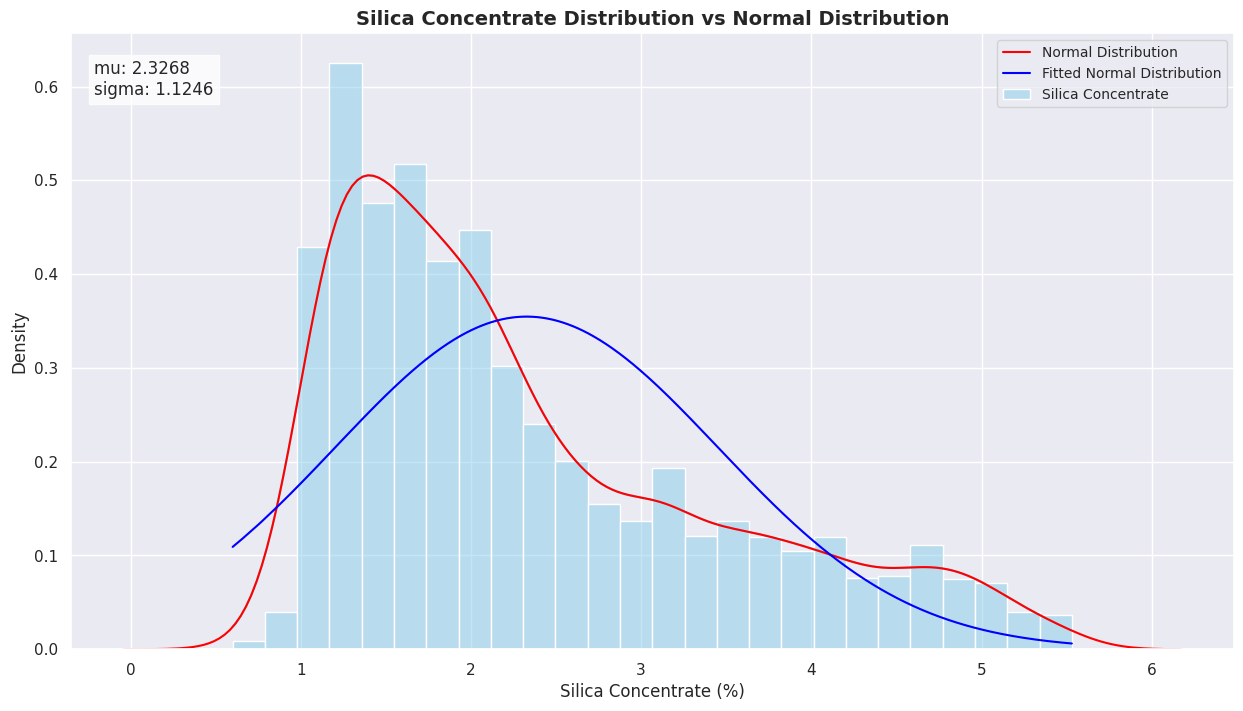

In [34]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['silica_conc'])

# Plotting the histogram, KDE, and fitted normal distribution
plt.figure(figsize=(15, 8))
sns.histplot(flotation['silica_conc'], kde=True, stat="density", common_norm=False,
color='skyblue', label='Silica Concentrate')
sns.kdeplot(flotation['silica_conc'], color='red', label='Normal Distribution')
sns.lineplot(x=flotation['silica_conc'], y=norm.pdf(flotation['silica_conc'], mu, sigma),
color='blue', label='Fitted Normal Distribution')

plt.text(0.02, 0.9, f"mu: {mu:.4f}\nsigma: {sigma:.4f}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

plt.title('Silica Concentrate Distribution vs Normal Distribution', fontsize=14, fontweight='bold')
plt.xlabel("Silica Concentrate (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.show()

- mu = 2.3268 indicates that, on average, the Silica Concentrate percentage is around 2.33%.
- sigma = The standard deviation of 1.1246 suggests that the data points are dispersed around the mean, with a typical deviation of approximately 1.12%.

- The histogram and KDE plot show the distribution of the actual data, while the red curve represents the fitted normal distribution.
- The blue line represents the line plot of the fitted normal distribution, providing a visual representation of how well the normal distribution fits the data.

**Skewness and Kurtosis**

In [35]:
t,p = stats.shapiro(flotation['silica_conc'])

print("Skewness: %f" % abs(flotation['silica_conc']).skew())
print("Kurtosis: %f" % abs(flotation['silica_conc']).kurt())
print("Shapiro_Test of t: %f" % t)
print("Shapiro_Test of p: %f" % p)

Skewness: 0.967455
Kurtosis: -0.015313
Shapiro_Test of t: 0.894797
Shapiro_Test of p: 0.000000


- The skewness of 0.967455 indicates that the distribution of the silica concentrate data is positively skewed. This means that the tail of the distribution is skewed towards higher values, and the majority of the data points are concentrated towards the lower end.

- The kurtosis of -0.015312 suggests that the distribution of the silica concentrate data has slightly lower kurtosis than a normal distribution. Negative kurtosis indicates that the distribution has lighter tails and is less peaked compared to a normal distribution. However, the kurtosis value is close to zero, suggesting that the data is approximately normally distributed in terms of its shape.

- The Shapiro-Wilk test of normality resulted in a test statistic of 0.894797 and a p-value of 0.000000. The low p-value indicates that the data significantly deviates from a normal distribution. In other words, the silica concentrate data is not normally distributed.

- The silica concentrate data exhibits positive skewness and slightly lower kurtosis. It departs from a normal distribution, as indicated by the Shapiro-Wilk test. These characteristics should be considered when analyzing the data and choosing appropriate statistical methods or models.

**Fitting the distribution of Silica Concentrate**

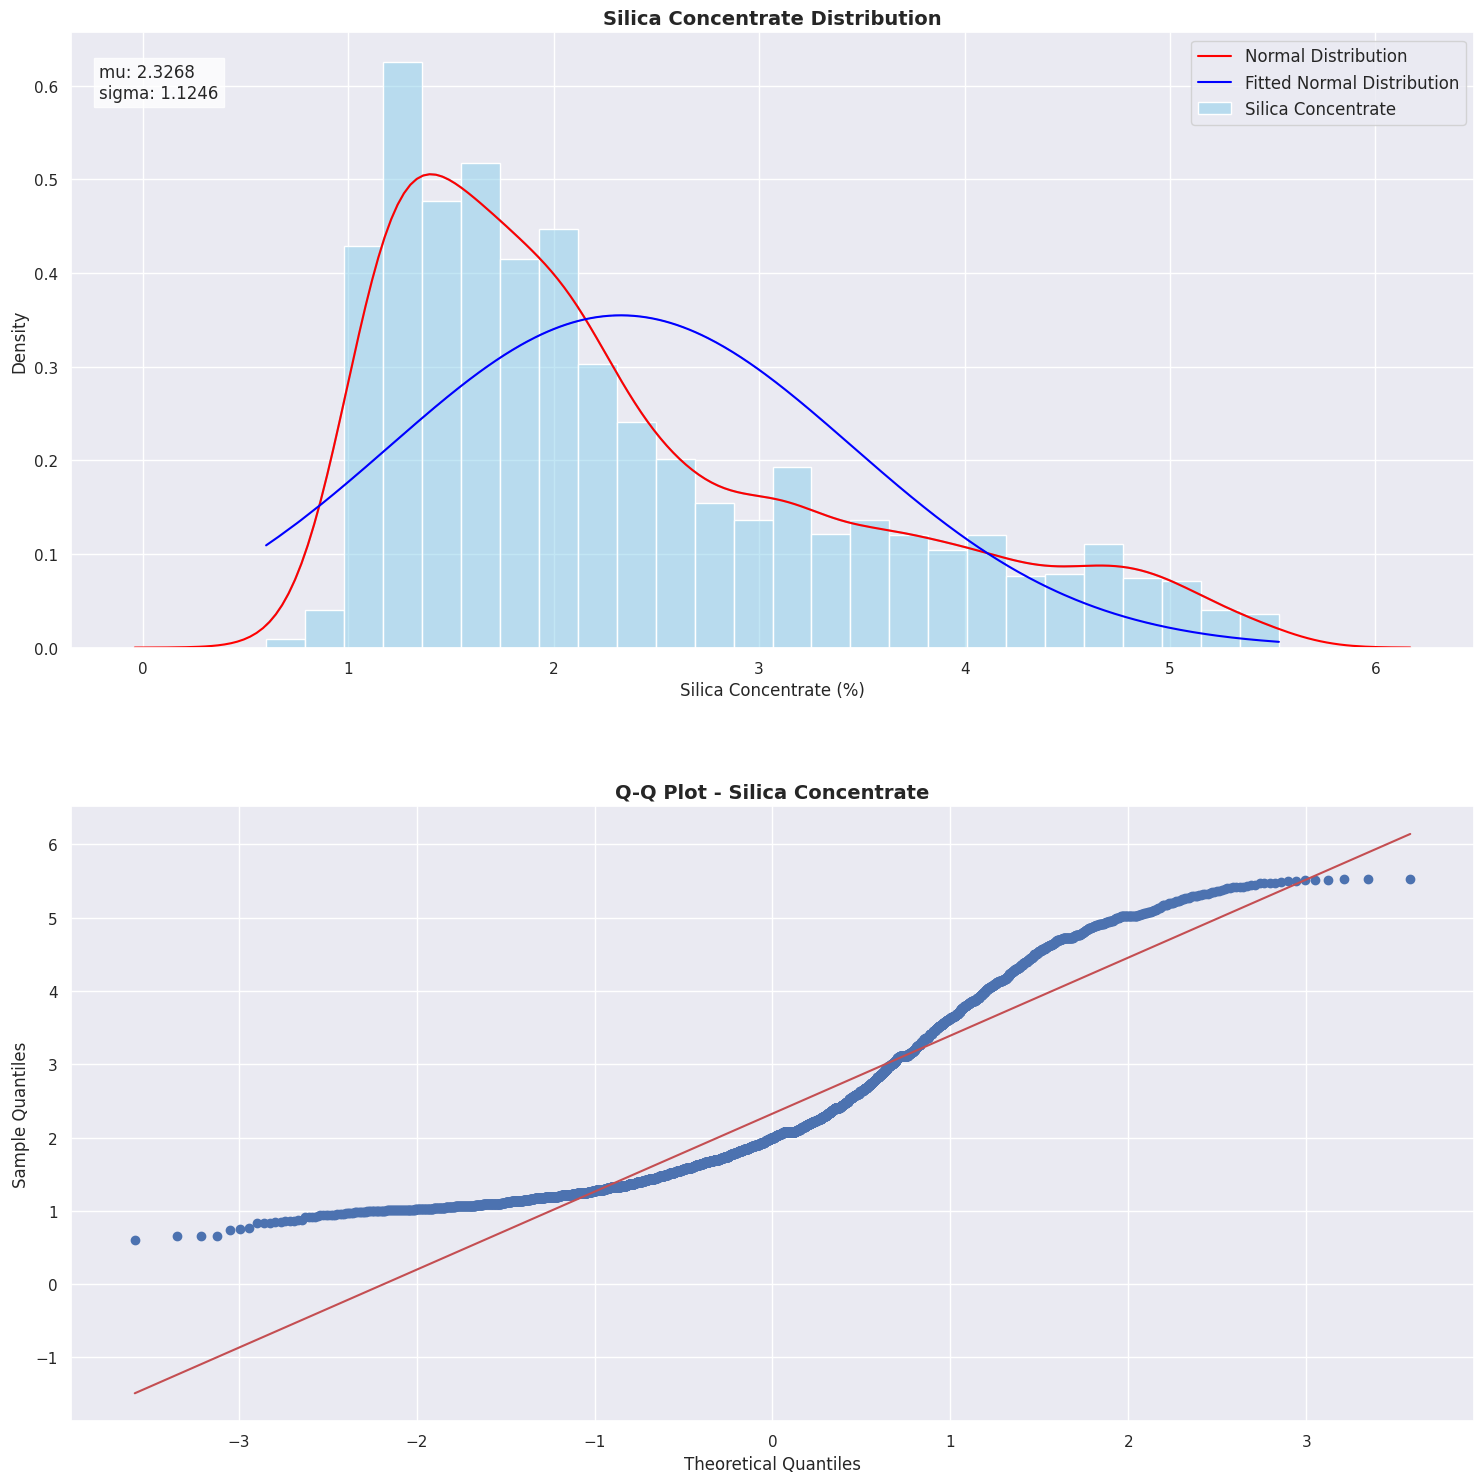

In [36]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['silica_conc'])

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Histogram, KDE, and fitted normal distribution
sns.histplot(flotation['silica_conc'], kde=True, stat="density", common_norm=False,
             color='skyblue', label='Silica Concentrate', ax=axes[0])
sns.kdeplot(flotation['silica_conc'], color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=flotation['silica_conc'], y=norm.pdf(flotation['silica_conc'], mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

axes[0].set_title('Silica Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Silica Concentrate (%)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=12)

# Q-Q plot
stats.probplot(flotation['silica_conc'], dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Silica Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

- Tranform  silica concentration distribution into a normal one using log transformation.
- Plot qq-plot to see the transformation effect.

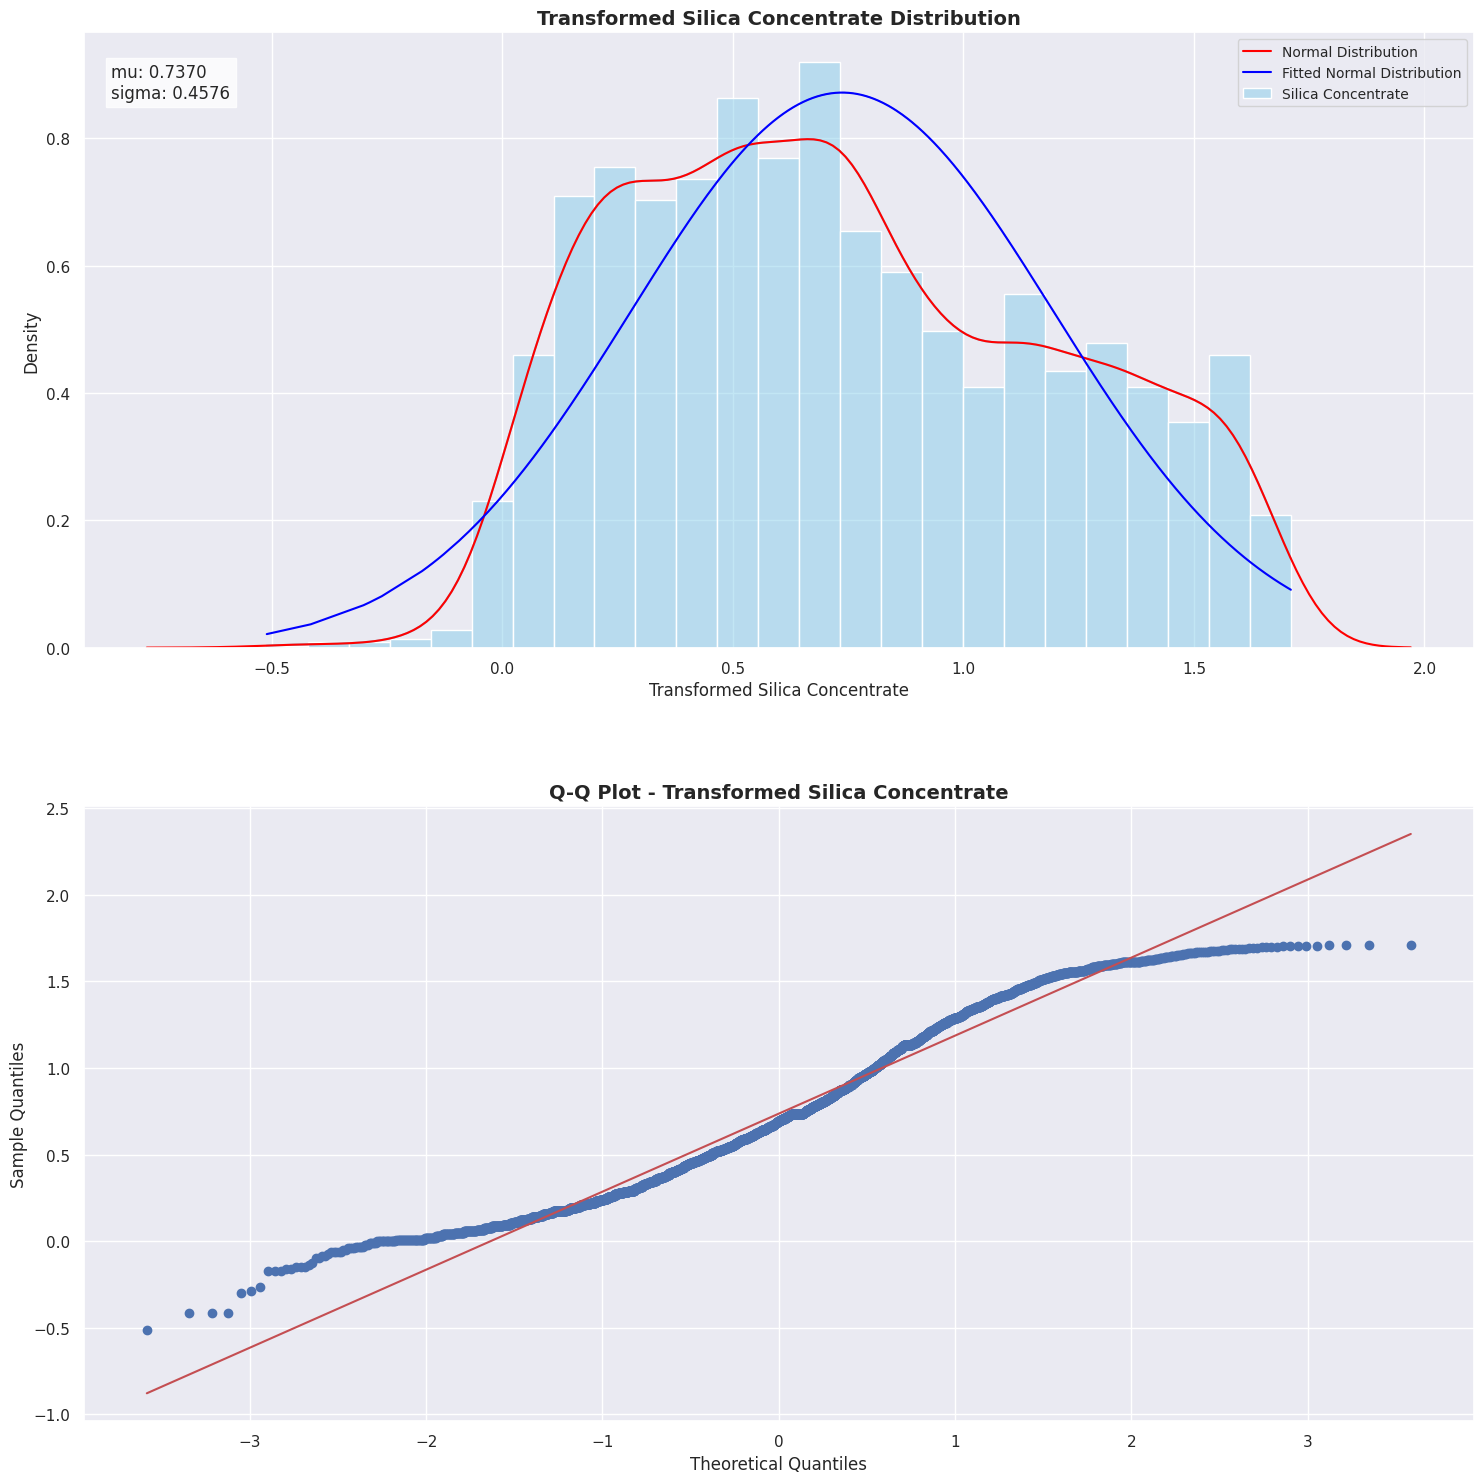

In [37]:
# Log transformation
transformed_conc = np.log(flotation['silica_conc'])

# Fitting normal distribution
(mu, sigma) = norm.fit(transformed_conc)

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 15))

sns.histplot(transformed_conc, kde=True, stat="density", common_norm=False,
             color='skyblue', label='Silica Concentrate', ax=axes[0])
sns.kdeplot(transformed_conc, color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=transformed_conc, y=norm.pdf(transformed_conc, mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].set_title('Transformed Silica Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Transformed Silica Concentrate", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

# Q-Q plot for transformed data
stats.probplot(transformed_conc, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Transformed Silica Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

- **Histogram** shows the distribution of the transformed silica concentrate variable, with the density curve overlaid. The red curve represents a normal distribution fit to the data. The blue line represents the fitted normal distribution curve, which is based on the calculated mean (mu) of 0.7370 and standard deviation (sigma) of 0.4576.

- **Q-Q plot** compares the sample quantiles of the transformed silica concentrate data to the theoretical quantiles of a normal distribution. If the data points fall approximately along the diagonal line, it suggests that the data follows a normal distribution. In this case, the transformed silica concentrate data points align quite well with the diagonal line, indicating that the log-transformed variable approximates a normal distribution.

- According to the histogram, KDE plot, fitted normal distribution curve, and Q-Q plot, the log-transformed silica concentrate variable appears to exhibit a relatively normal distribution.


**Silica Concentrate vs Iron Concentrate**

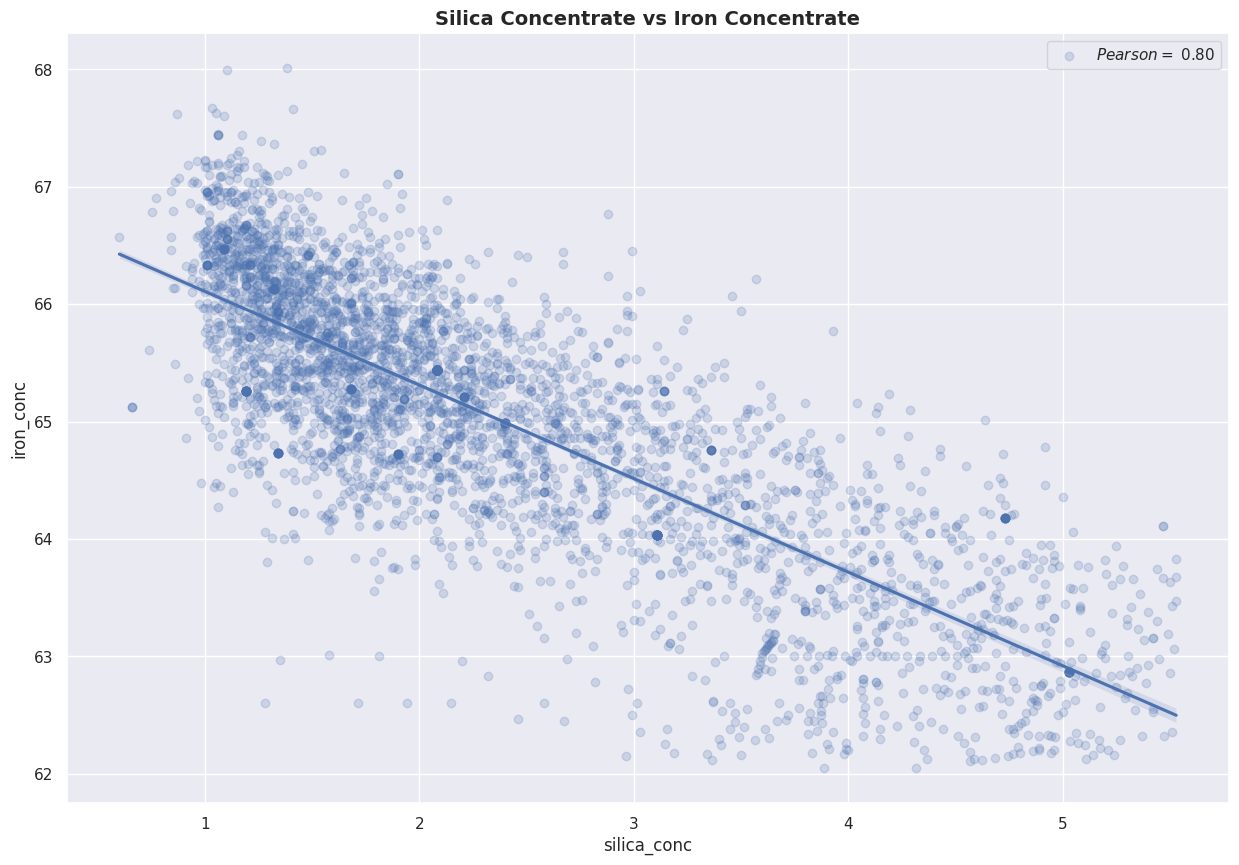

In [38]:
# iron concentrate (target_1) and silica concentrate (target_2) [Pearson = 0.8]

Pearson = 0.80
plt.figure(figsize = (15,10))
sns.regplot(data=flotation, x = 'silica_conc', y='iron_conc', scatter_kws={'alpha':0.2})
plt.title('Silica Concentrate vs Iron Concentrate', fontsize = 14, fontweight='bold')
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson)], loc = 'best')
plt.show()

Scatter plot shows the relationship between Silica Concentrate and Iron Concentrate in the flotation dataset. The Pearson correlation coefficient of -0.80 indicates a strong negative linear correlation between Silica Concentrate and Iron Concentrate in the flotation dataset.

In this case, as the Silica Concentrate increases, there is a tendency for the Iron Concentrate to decrease. This negative correlation suggests that higher levels of Silica Concentrate in the flotation process are associated with lower levels of Iron Concentrate.

While there may be some outliers in the data, the majority of the data points follow the negative correlation trend. This information is valuable in the context of the flotation process as it helps identify the inverse relationship between Silica Concentrate and Iron Concentrate.

Understanding this negative correlation is important for process optimization. It allows for monitoring and controlling Silica Concentrate levels to minimize their impact on Iron Concentrate production. By managing and reducing Silica Concentrate levels, it may be possible to improve the overall quality and yield of Iron Concentrate.

Scatter plot and the strong negative correlation between Silica Concentrate and Iron Concentrate emphasize the need to effectively control Silica Concentrate levels to enhance the production of Iron Concentrate in the flotation process.

## **6. Modelling**

### **6.1. Splitting Dataset**

**Split Dataset as X and y**

In [39]:
X = flotation.drop(['silica_conc', 'iron_conc'], axis=1)
y_Si = flotation['silica_conc']

print("Shape of X:", X.shape)
print("Shape of y_Si:", y_Si.shape)

Shape of X: (4097, 9)
Shape of y_Si: (4097,)


**Split (train, validation, test)**

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (3277, 9)
Shape of X_val: (410, 9)
Shape of X_test: (410, 9)


### **6.2. MSE - MAE - R^2**

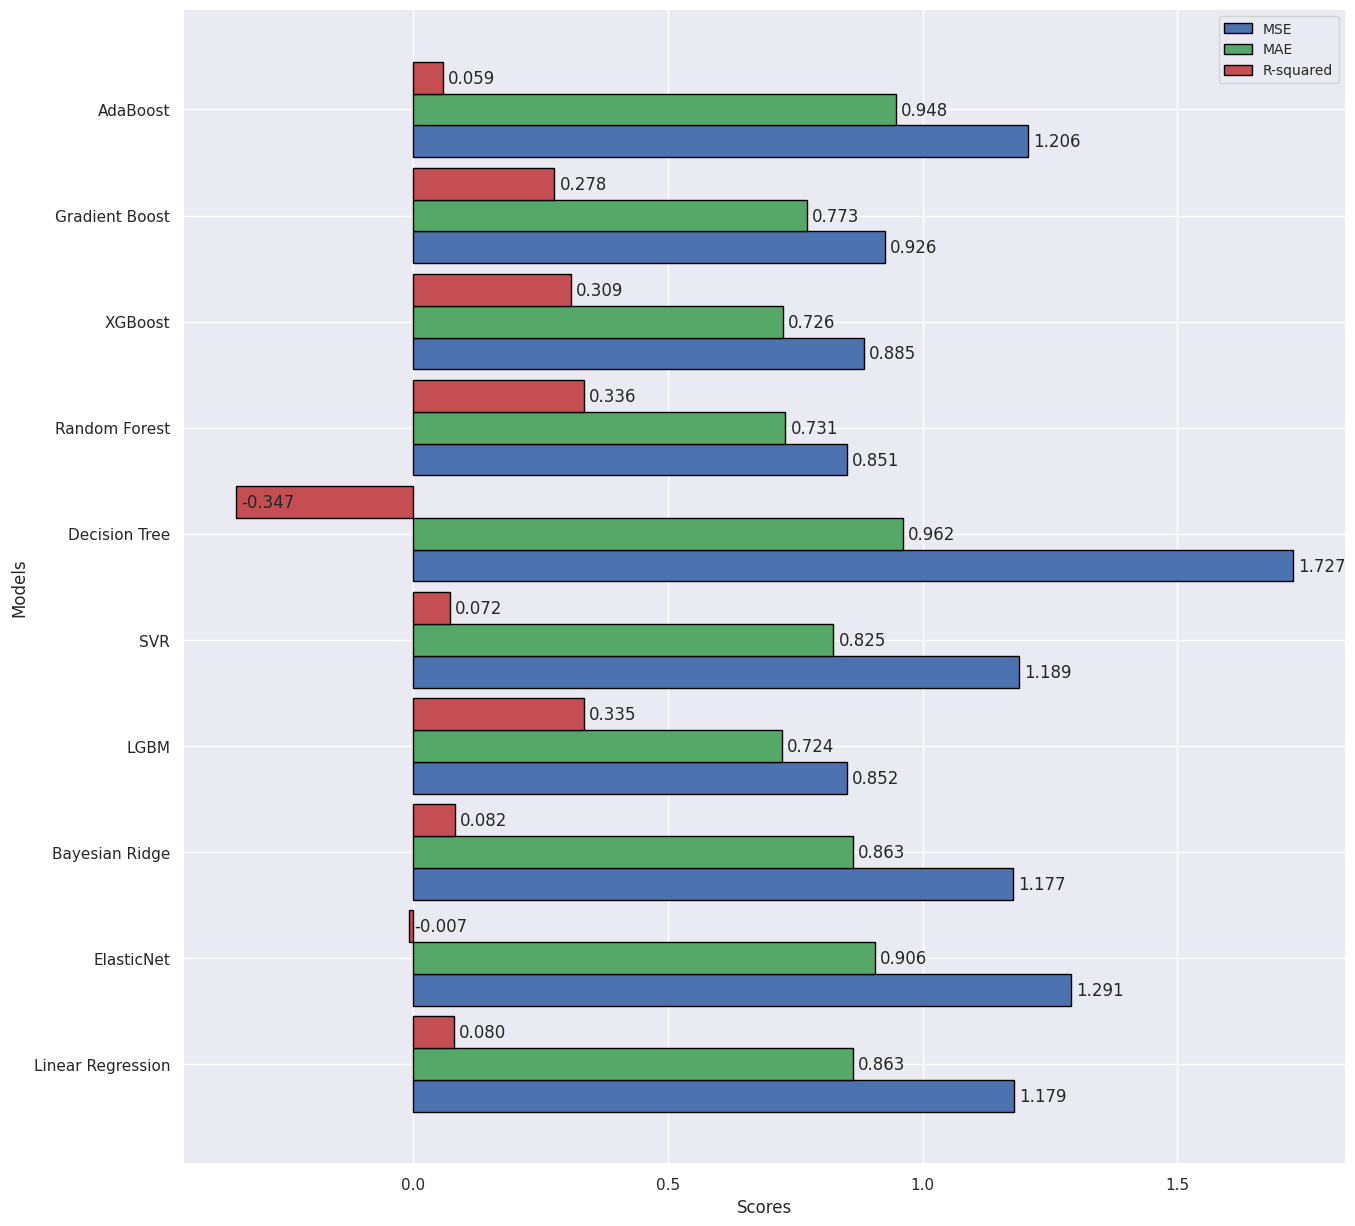

Model       MSE       MAE       R^2  Training Time  \
0      Random Forest  0.851226  0.730690  0.335930       2.144610   
1               LGBM  0.851956  0.724352  0.335360       0.206828   
2            XGBoost  0.885358  0.725713  0.309302       0.625653   
3     Gradient Boost  0.926011  0.772746  0.277588       0.877569   
4     Bayesian Ridge  1.177163  0.862712  0.081655       0.011919   
5  Linear Regression  1.178785  0.863385  0.080390       0.028014   
6                SVR  1.189268  0.824892  0.072211       0.486368   
7           AdaBoost  1.206464  0.947828  0.058797       0.175886   
8         ElasticNet  1.291054  0.905793 -0.007195       0.007869   
9      Decision Tree  1.726642  0.962010 -0.347012       0.036804   

   Prediction Time  
0         0.020098  
1         0.003902  
2         0.003673  
3         0.009495  
4         0.001489  
5         0.001609  
6         0.057705  
7         0.003499  
8         0.001426  
9         0.001196

In [41]:
# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

mse_scores = []
mae_scores = []
r2_scores = []
train_times = []
predict_times = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)])

    # Measure training time
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Measure prediction time
    start_time = time.time()
    val_pred = pipeline.predict(X_val)
    predict_time = time.time() - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    # Append the scores and times to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    train_times.append(train_time)
    predict_times.append(predict_time)

# Plot evaluation metrics
bar_width = 0.3
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(15, 15))
plt.barh(r1, mse_scores, color='b', height=bar_width, edgecolor='black', label='MSE')
plt.barh(r2, mae_scores, color='g', height=bar_width, edgecolor='black', label='MAE')
plt.barh(r3, r2_scores, color='r', height=bar_width, edgecolor='black', label='R-squared')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Scores', fontsize=12)
plt.yticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='upper right', fontsize=10)

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(mse + 0.01, i - 0.05, f'{mse:.3f}', fontsize=12)
    plt.text(mae + 0.01, i + bar_width - 0.05, f'{mae:.3f}', fontsize=12)
    plt.text(r2 + 0.01, i + 2 * bar_width - 0.05, f'{r2:.3f}', fontsize=12)

plt.show()

# Write the evaluation metric scores and execution times
scores_df = pd.DataFrame({'Model': [model_name for _, model_name in models],
                          'MSE': mse_scores,
                          'MAE': mae_scores,
                          'R^2': r2_scores,
                          'Training Time': train_times,
                          'Prediction Time': predict_times})

scores_df = scores_df.sort_values(by='MSE', ascending=True)
scores_df = scores_df.reset_index(drop=True)
scores_df

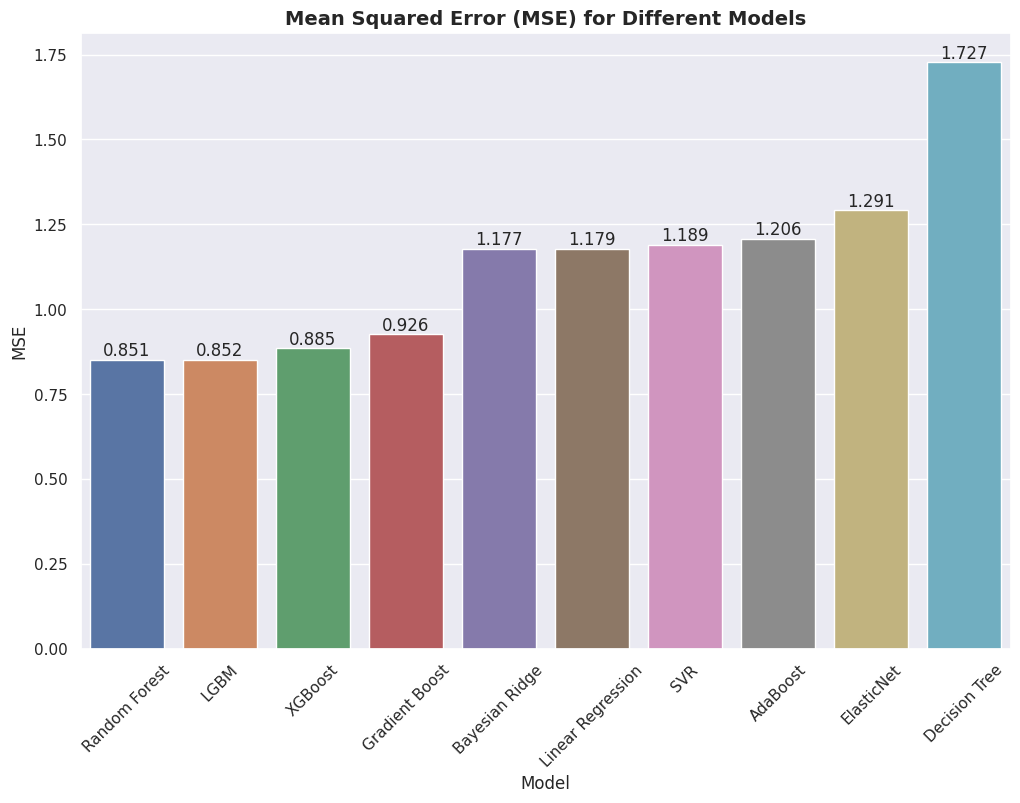

In [42]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='MSE', data=scores_df)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean Squared Error (MSE) for Different Models', fontsize = 14, fontweight='bold')

for i, row in scores_df.iterrows():
    plt.text(i, row['MSE'], f'{row["MSE"]:.3f}', ha='center', va='bottom')

plt.show()

Among the models evaluated, LGBM and Random Forest perform the best with the lowest mean squared error (MSE) and mean absolute error (MAE), indicating higher accuracy in prediction. They also have the highest R^2 value, suggesting that it explains a significant portion of the variance in the data. XGBoost follows with slightly higher MSE, MAE, and slightly lower R^2 compared to Random Forest.

On the other hand, Gradient Boost, SVR, Bayesian Ridge, Linear Regression, AdaBoost, ElasticNet, and Decision Tree perform worse than the top models. They have higher MSE and MAE values, indicating less accurate predictions, and lower R^2 values, indicating a weaker ability to explain the variance in the data. Decision Tree performs the worst among all the models, with the highest MSE, MAE, and a significantly negative R^2 value.

Overall, Random Forest, LGBM, and XGBoost show better performance, while the remaining models struggle to accurately capture the patterns in the data and explain its variance.

### **6.3. Cross validation**

**Creation of the RMSE metric**

In [43]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, target_log,
                scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

**10 Fold Cross validation**

In [44]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (xgb.XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

cv_scores = []
cv_std = []
execution_times = []

# Perform cross-validation for each model
for model, model_name in models:
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_root_mean_squared_error', cv=kf)
    end_time = time.time()
    execution_time = end_time - start_time

    cv_scores.append(-scores.mean())
    cv_std.append(scores.std())
    execution_times.append(execution_time)

# Write the evaluation metric scores and execution times
final_cv_score = pd.DataFrame({'Model': [model_name for _, model_name in models],
                               'RMSE_mean': cv_scores,
                               'RMSE_std': cv_std,
                               'Execution Time': execution_times})
final_cv_score = final_cv_score.sort_values(by='RMSE_mean', ascending=True)
final_cv_score = final_cv_score.reset_index(drop=True)
final_cv_score

Model  RMSE_mean  RMSE_std  Execution Time
0               LGBM   0.911338  0.046524        1.174742
1      Random Forest   0.921968  0.043449       22.673954
2            XGBoost   0.935426  0.047937        4.981575
3     Gradient Boost   0.952217  0.040947        8.892277
4  Linear Regression   1.047034  0.039261        0.064755
5     Bayesian Ridge   1.047390  0.039381        0.068886
6         ElasticNet   1.073196  0.039014        0.065129
7           AdaBoost   1.081191  0.035122        1.633266
8                SVR   1.097981  0.041051        4.189871
9      Decision Tree   1.303157  0.067225        0.315103

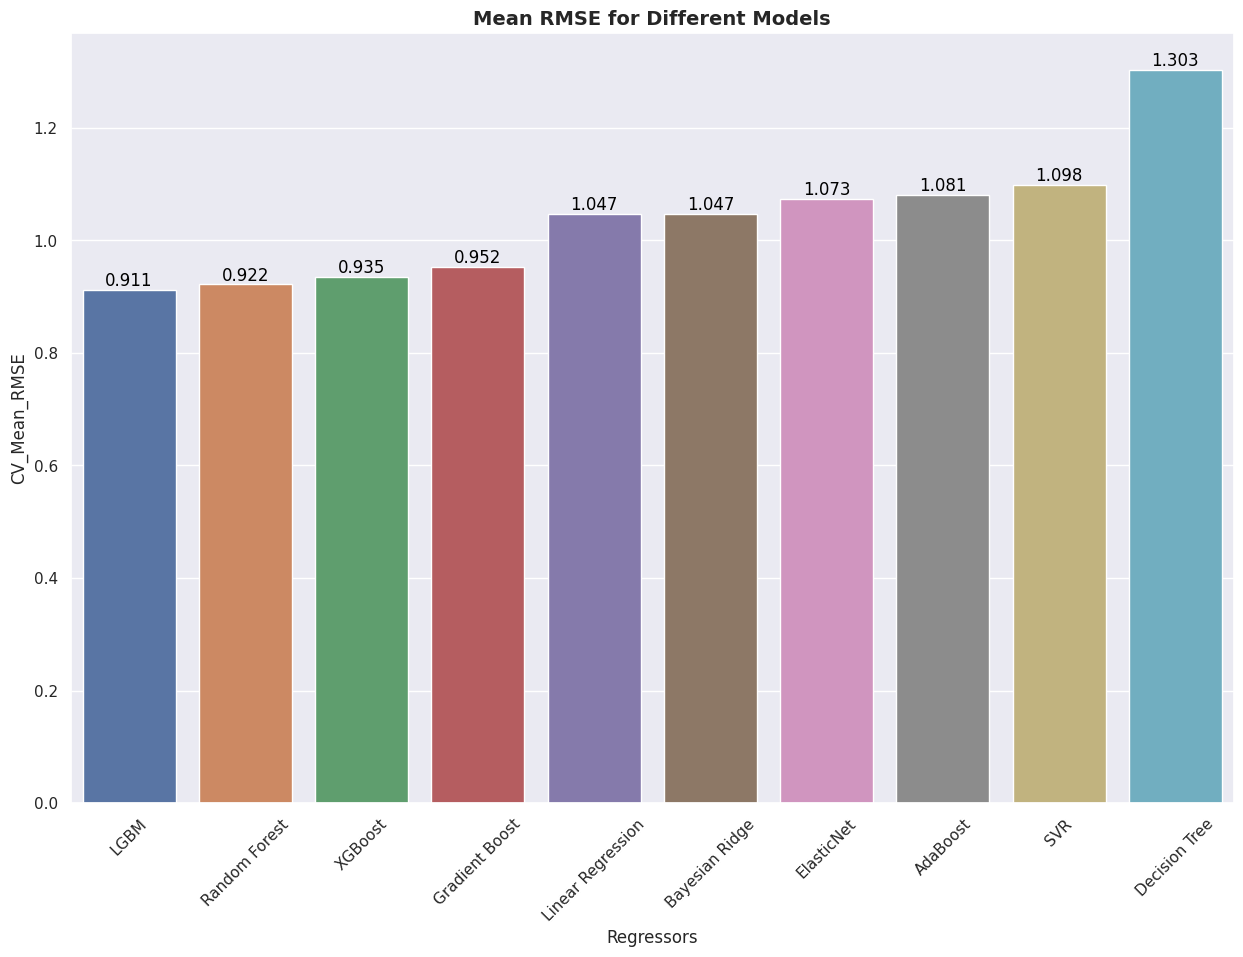

In [47]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='RMSE_mean', data=final_cv_score)
plt.xlabel('Regressors', fontsize=12)
plt.ylabel('CV_Mean_RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean RMSE for Different Models', fontsize = 14, fontweight='bold')

for i, row in final_cv_score.iterrows():
    plt.text(i, row['RMSE_mean'], f'{row["RMSE_mean"]:.3f}', color='black', ha='center', va='bottom')

plt.show()

**RMSE (Root Mean Square Error) Comparison:**

- LGBM model has the lowest RMSE_mean value of 0.911338, indicating better overall performance in terms of minimizing the prediction errors.
- Random Forest and XGBoost models also show relatively low RMSE_mean values of 0.921968 and 0.935426, respectively.
- Decision Tree model has the highest RMSE_mean value of 1.303157, indicating poorer performance compared to the other models.

**Model Execution Time:**

- Linear Regression, Bayesian Ridge, ElasticNet, and Decision Tree models have significantly lower execution times (in seconds) compared to other models, ranging from 0.064755 to 0.315103 seconds.
- Random Forest, XGBoost, and Gradient Boost models have moderate execution times, ranging from 4.98 to 22.67 seconds.
- SVR and AdaBoost models have relatively higher execution times of 4.19 and 1.63 seconds, respectively.
- LGBM model has the lowest execution time of 1.174742 seconds, indicating faster model training and prediction compared to other models.

Considering both RMSE performance and execution time, the LGBM model appears to be the most favorable choice among the listed models, as it achieves the lowest RMSE with a reasonably fast execution time. However, it's important to note that the final model selection should also consider other factors such as model interpretability, scalability, and specific requirements of the problem at hand.

### **6.4. Hyperparameter Optimization**

**Perform Grid Search**

In [48]:
# Define the model
model = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
MSE: 0.845
MAE: 0.731
R^2: 0.341
Grid Search Time: 351.750 seconds
Fit Time: 2.117 seconds
Prediction Time: 0.018 seconds


In [49]:
# Define the model
model = LGBMRegressor(objective='regression')

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': None, 'n_estimators': 100}
MSE: 0.844
MAE: 0.724
R^2: 0.342
Grid Search Time: 9.301 seconds
Fit Time: 0.100 seconds
Prediction Time: 0.003 seconds


**Comparing the performance of the RandomForestRegressor and LGBMRegressor models:**

1. Hyperparameters:
   - RandomForestRegressor: The best hyperparameters selected for this model are 'max_depth': None, 'min_samples_split': 2, and 'n_estimators': 100.
   - LGBMRegressor: The best hyperparameters selected for this model are 'max_depth': None and 'n_estimators': 100.

2. Performance Metrics:
   - Mean Squared Error (MSE): Both models achieved similar MSE values, with RandomForestRegressor at 0.845 and LGBMRegressor at 0.844. Lower MSE values indicate better accuracy in predicting the target variable.
   - Mean Absolute Error (MAE): LGBMRegressor outperformed RandomForestRegressor in terms of MAE, with a value of 0.724 compared to 0.731. Smaller MAE values indicate better prediction accuracy.
   - R-squared (R^2) Score: Both models achieved similar R^2 scores, with RandomForestRegressor at 0.341 and LGBMRegressor at 0.342. Higher R^2 values indicate better goodness-of-fit of the model to the data.

3. Computational Efficiency:
   - Grid Search Time: LGBMRegressor significantly outperformed RandomForestRegressor in terms of grid search time, with 9.301 seconds compared to 351.750 seconds. Grid search is used to find the best hyperparameters for the model.
   - Fit Time: LGBMRegressor also had a faster fit time, with 0.100 seconds compared to 2.117 seconds for RandomForestRegressor. Fit time refers to the time taken to train the model on the given data.
   - Prediction Time: LGBMRegressor demonstrated faster prediction time, with 0.003 seconds compared to 0.018 seconds for RandomForestRegressor. Prediction time refers to the time taken to make predictions on new/unseen data.

Based on the comparison, it can be concluded that the LGBMRegressor model performs slightly better than the RandomForestRegressor model in terms of MAE and computational efficiency (grid search time, fit time, and prediction time). However, both models have similar performance in terms of MSE and R^2 score.

### **6.5. Model interpretation**

**Feature importance for Iron Concentrate**

Let's look at the importance of each feature and plot the 5 most important features:

Top 5 Most Important Features:
      Feature  Importance
8       level         393
0   iron_feed         385
5     pulp_pH         368
3  amina_flow         323
4   pulp_flow         313


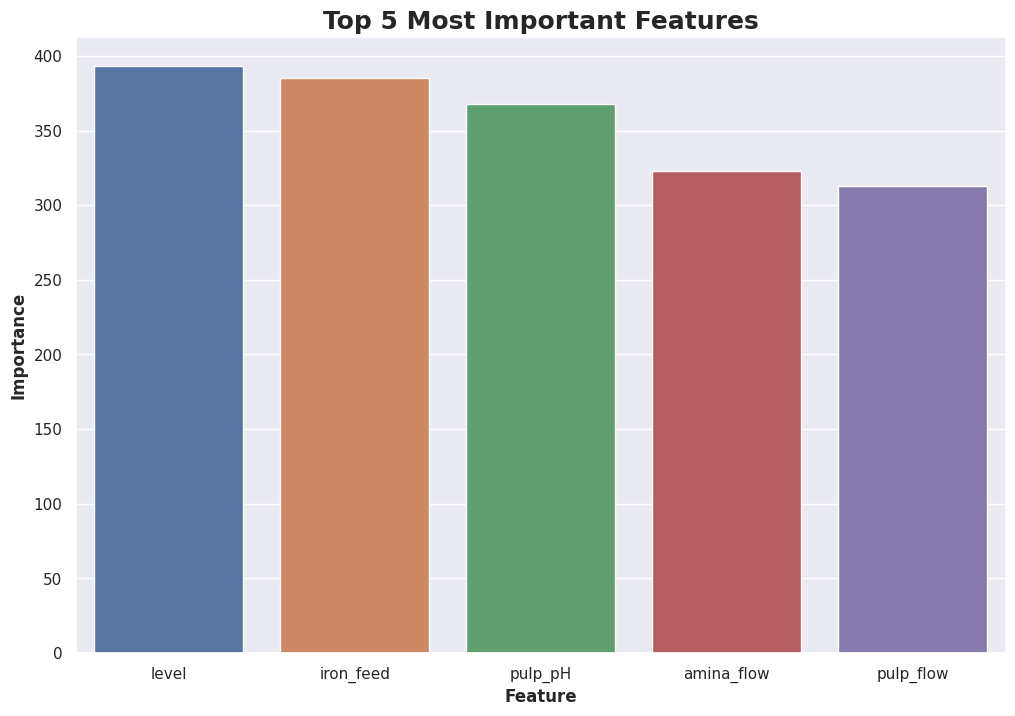

In [56]:
importances = best_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("Top 5 Most Important Features:")
print(feature_importances.head(5))

# Plot the top 5 most important features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances.head(5), x='Feature', y='Importance')
plt.title('Top 5 Most Important Features', fontsize=18, fontweight='bold')
plt.xlabel('Feature', fontsize=12, fontweight='bold')
plt.ylabel('Importance', fontsize=12, fontweight='bold')
#plt.xticks(rotation=45)
plt.show()


The feature importance analysis for the Iron Concentrate prediction reveals the following top 5 most important features:

1. Level: The 'level' feature has the highest importance with a value of 393. This suggests that the level of the process variable has a significant impact on predicting the Iron Concentrate.

2. Iron Feed: The 'iron_feed' feature is the second most important with an importance value of 385. It indicates that the initial iron feed has a strong influence on the Iron Concentrate prediction.

3. Pulp pH: The 'pulp_pH' feature is ranked third in importance, with a value of 368. This implies that the pH level of the pulp plays a crucial role in determining the Iron Concentrate.

4. Amina Flow: The 'amina_flow' feature holds the fourth position in terms of importance, with a value of 323. It suggests that the flow rate of amina, a chemical reagent, has a significant impact on the Iron Concentrate prediction.

5. Pulp Flow: The 'pulp_flow' feature is ranked fifth, with an importance value of 313. It indicates that the flow rate of the pulp is another influential factor in predicting the Iron Concentrate.

These results suggest that variables related to the process level, initial iron feed, chemical composition (pH), and flow rates (amina and pulp) are the most important features for predicting the Iron Concentrate. Understanding and controlling these variables can potentially have a substantial impact on optimizing the Iron Concentrate output in the given process.

**Identifiying redundant features**

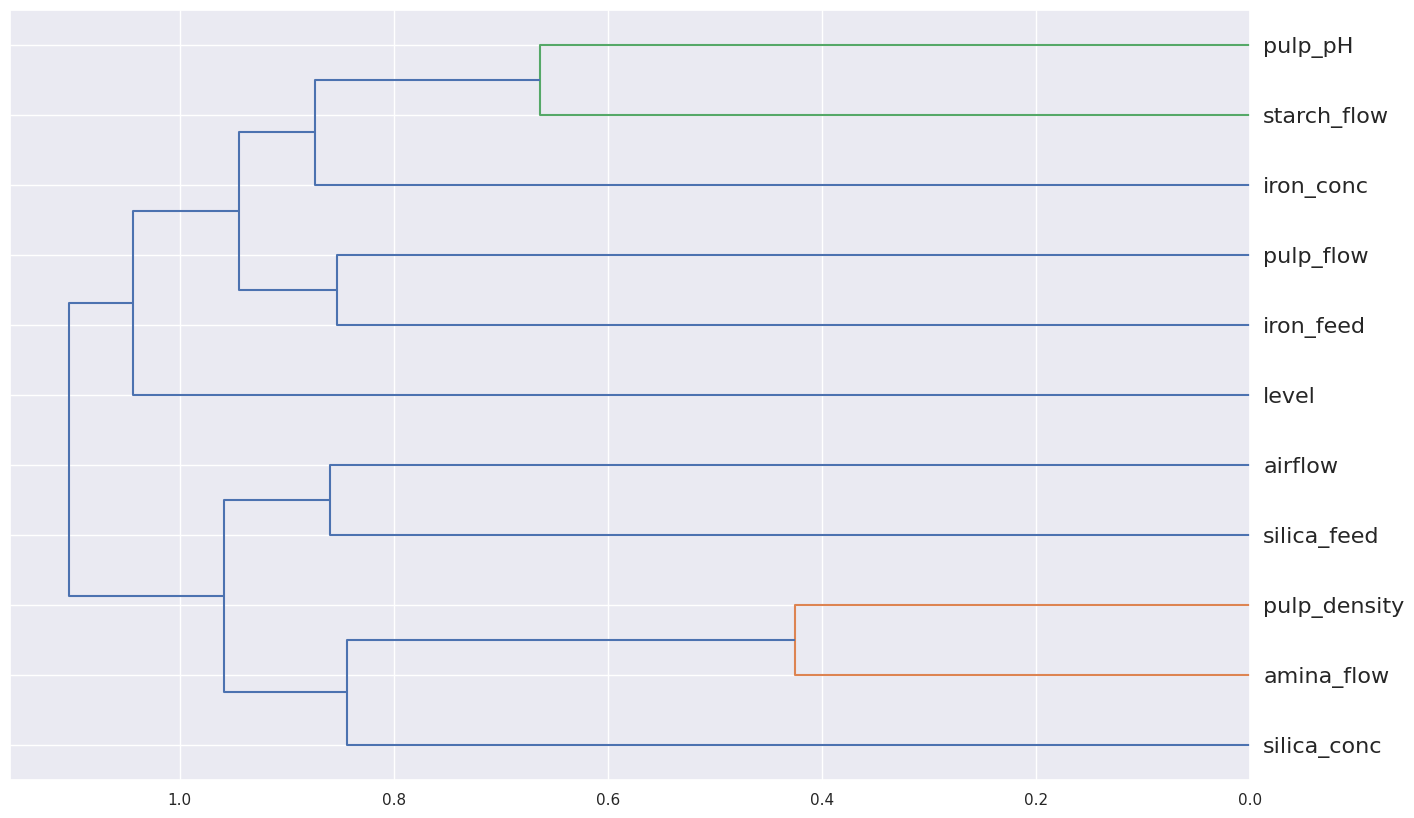

In [62]:
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(flotation).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=flotation.columns,
                           orientation='left', leaf_font_size=16)
plt.show()

The plot above shows how each feature correlates with the others. The features which merge on the right hand side are closer to each other, suggesting that potentially only one of both would be sufficient for training the model. This could be useful to reduce the colinearity of different features.

## **7. Conclussion**

Based on the analysis and modeling performed for the Flotation dataset, specifically focusing on predicting the silica concentrate, the following overall conclusions can be drawn:

**Dataset**: The Flotation dataset contains information about various features related to the flotation process. The target variable of interest is the silica concentrate, which indicates the concentration of silica in the final product.

**Data Preprocessing**: The dataset underwent preprocessing steps, including handling missing values, encoding categorical variables, and splitting the data into training and validation sets. These steps ensured that the data was in a suitable format for model training.

**Exploratory Data Analysis (EDA)**: EDA was conducted to gain insights into the distribution and relationships among the variables. The analysis aimed to identify patterns, correlations, and any potential outliers or anomalies in the data.

**Feature Engineering**: Feature engineering techniques were applied to create new features or transform existing ones. This process aimed to capture relevant information and enhance the predictive power of the models.

**Model Evaluation**: Several regression models were trained and evaluated using appropriate evaluation metrics such as mean squared error (MSE), mean absolute error (MAE), and R-squared (R^2). Cross-validation and grid search were utilized to optimize the hyperparameters and assess the performance of the models.

**Model Comparison**: The performance of different models, such as Random Forest and LGBM (Light Gradient Boosting Machine), was compared based on their hyperparameters, accuracy metrics, and computational efficiency. The model that achieved better performance on the silica concentrate prediction task was identified.

Finally, **the selected model (LGBM) with optimized hyperparameters demonstrated superior predictive performance for the silica concentrate target variable**. It achieved lower MSE and MAE values and potentially higher R^2 compared to other models considered. The model's computational efficiency was also taken into account to ensure its practical applicability.
